# Imports

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector
import os
import json
from sys import getsizeof
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.metrics import jaccard_score

from typing import List

import src.utils.utils as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'src.utils.utils' from 'c:\\Users\\vvval\\Documents\\EPFL\\ada-2024-project-thedataminions\\src\\utils\\utils.py'>

# Configure path to data files

In [3]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
#dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "/media/andreas/Backup_Louanne/Youniverse_dataset/" #Lou-Anne at andreas pc
dataset_root_path = "D:/ada_project/dataset/"                                    #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon
# dataset_root_path = "/Volumes/Backup/Youniverse_dataset/" #Lou-Anne 
#dataset_root_path = "/Volumes/Disk Horti/Youniverse_dataset/" #Horti

# Part 1 : Data handling and filtering

## Loading the data - done in order to know how the data looks like

In [5]:
# load channel data (no chunks needed, as the file is not very large)


df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") 

In [ ]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data

df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) 

# load (first 1000000 rows of) comment data

df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000)

In [5]:
def videos_in_chunks( chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", 
                        compression="infer", lines=True, chunksize=chunksize,)
                        #nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", 
                       compression="infer", sep="\t", chunksize=chunksize, )
                       #nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                          # (remove the paranthesis above as well)

## Filtering for NaNs,empty values and possible spaces

## 1. Analyzing if filtering is needed

In [20]:
#to create the filepath for the different get entries below , need to have "../generated_data" which exists:

# Define the path to the directory
output_dir = os.path.join(dataset_root_path, "../generated_data")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

First we get all values that are NaN, empty and spaces in order to decide how we will treat the data, and if cleaning the data is needed. 

### a. Youtube Comments 

In [ ]:
# get the entries of the comment dataframe which have a NaN value, empty string or space in any column

nans_empty_space_comments_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_comment_dataset.csv"  # path to file with nans in comment dataset

try:  # try to read the data from file
    df_nans_empty_space_in_comments = pd.read_csv(nans_empty_space_comments_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_comments = dp.run_simple_function_on_chunks_concat(comments_in_chunks(1000000), 
                                                                              lambda x: dp.get_na_empty_space_entries(x, "any", reverse=False),
                                                                              print_time=(1000000, 8600000000))
    
    df_nans_empty_space_in_comments.to_csv(nans_empty_space_comments_filepath, index=False)


Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
5.342 secs per chunk on average. Meaning  765.630 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
5.445 secs per chunk on average. Meaning  780.214 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
5.530 secs per chunk on average. Meaning  792.319 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
5.548 secs per chunk on average. Meaning  794.801 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
5.601 secs per chunk on average. Meaning  802.413 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
5.635 secs per chunk on average. Meaning  807.109 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

: 

### b. Videos (youtube metadata)

In [ ]:
# get the entries of the video dataframe which have a NaN value, empty string or space in any column

nans_empty_space_videos_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_video_dataset.csv"  # path to file with nans in video dataset

try:  # try to read the data from file
    df_nans_empty_space_in_videos = pd.read_csv(nans_empty_space_videos_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_videos = dp.run_simple_function_on_chunks_concat(videos_in_chunks(), 
                                                                            lambda x: dp.get_na_empty_space_entries(x, "any", reverse=False),
                                                                            print_time=(1000000, 8600000000))
    df_nans_empty_space_in_videos.to_csv(nans_empty_space_videos_filepath, index=False)

### c. Channels

In [ ]:
# get the entries of the channel dataframe which have a NaN value, empty string or space in any column

nans_empty_space_channels_filepath = dataset_root_path + "../generated_data/nan_empty_space_rows_in_channel_dataset.csv"  # path to file with nans in channel dataset

try:  # try to read the data from file
    df_nans_empty_space_in_channels = pd.read_csv(nans_empty_space_channels_filepath)
except FileNotFoundError:  # if the file is not found...
    # ... then generate the file
    df_nans_empty_space_in_channels = dp.get_na_empty_space_entries(df_channels, "any", reverse=False)

    df_nans_empty_space_in_channels.to_csv(nans_empty_space_channels_filepath, index=False)

In [ ]:
#display to be sure this are not empty, alarming us that some data need to be discard.

display(df_nans_empty_space_in_comments)
display(df_nans_empty_space_in_videos)
display(df_nans_empty_space_in_channels)

,author,video_id,likes,replies,char


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,char
2037,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:29:13.871524,Play all my games at http://www.retrogamer3.co...,NaN,KdoFvAgj2pA,647,NaN,"NES,Disassemble,RetroGamer3,72,pin,card,replac...",NES Disassemble by RetroGamer3,2011-10-25 00:00:00,16742.0,na
2615,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:40.351811,FREE POKECOINS HERE!\nStep by Step Guide:\n1. ...,NaN,Rigecg1Tw3Q,87,NaN,"Pokemon Go,Pokemon,go,free,pokemon go pokecoin...",FREE UNLIMITED POKECOINS :: POKEMON GO :: MORE...,2016-07-12 00:00:00,46635.0,na
7937,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:22:01.132899,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,z1IBWQusOWc,55,NaN,"piano,pianist,cover,live,musician,creative,tut...",50 Cent - In Da Club (Piano Tutorial),2019-04-24 00:00:00,5790.0,na
7977,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:22:30.010478,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,gIm1ETMO-hE,269,NaN,"piano,pianist,cover,live,musician,creative,tut...",Awolnation - Sail (Piano Tutorial),2019-04-14 00:00:00,15617.0,na
7987,Music,UCzWLloEwMWZYnUErRF5WWCg,2019-11-19 14:21:37.516545,DOWNLOAD FOR FREE MY 10 TIPS CHECKLIST TO HELP...,NaN,cLJw8DHyJBE,149,NaN,"piano,pianist,cover,live,musician,creative,tut...",Fortnite Better Give Me My Kids Back (Fgteev) ...,2019-03-13 00:00:00,18663.0,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999876,People & Blogs,UCrUkgG9ychiQ0WvbiwdlP1w,2019-11-13 20:40:53.349743,Support future streams: Buy me a Ko-fi!\nhttps...,8.0,q9hFysLAjUk,8397,351.0,,Goth GF Starfire Mukbang,2018-03-31 00:00:00,38147.0,empty
999953,Howto & Style,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:59.554309,http://twitch.tv/thekingkevin\n\nSubscribe to ...,0.0,BMG0qrEiP3Q,25,34.0,,I'm on Twitch?! [Updated],2016-02-15 00:00:00,1653.0,empty
999955,Howto & Style,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:05.734691,,NaN,P-b9O9WwPaY,1530,NaN,,Answers to Q&A - Pen Spinning Stuff,2015-05-24 00:00:00,9298.0,empty
999958,Science & Technology,UCrUfjMyHTAMQ8_OnM2nJFlw,2019-11-22 20:07:07.629776,"So as many of you probably know, the new iPhon...",6.0,tFhgS6EX-CM,13,285.0,,Pen Spinning at 120fps (iPhone 5S),2013-10-26 00:00:00,20570.0,empty


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,char
62,Entertainment,NaN,UCBR8-60-B28hp2BmDPdntcQ,YouTube,28200000,301,110.0,2.0870,na
6941,NaN,2009-05-12,UCa_4DcdTB9QfK0LY9-7qWuQ,AbbaVEVO,995000,36,17265.0,2.8200,na
8295,NaN,2012-12-23,UCVOftvvuyipcn7102TUFsSQ,Baka Oppai,760128,27,21172.0,2.9225,na
8885,NaN,2009-06-05,UCqH2YMSzMaGN92Vc3VkhWnQ,Sony Pictures Home E...,770000,6561,22799.0,2.9595,na
10449,NaN,2009-10-15,UCnzCV_PxVZ-hsOrTy2NGxJw,EuropeVEVO,654000,19,27450.0,2.9825,na
...,...,...,...,...,...,...,...,...,...
135072,NaN,2012-02-04,UCfRjxraogo4vwPSajqZUnhg,Johnny Marsiglia & B...,10300,22,935163.0,24.2090,na
135287,NaN,2009-03-18,UCBkyyLkDRd_iql_OWY87BOA,SHARKSANDCREATURES,10500,139,937947.0,28.1220,na
135326,NaN,2016-07-24,UCfL3FVHRncVVoBnVI_EI8vw,spoiled milk,10600,33,938514.0,28.9550,na
136264,NaN,2013-01-28,UC1uzi-DavAwqFp4SWR3XKfA,THEKONDOR,10300,108,977157.0,53.1435,na


### Analysis
We created dataframes composed of the rows containing empty, space and NaN characters of the inital dataframes, for the videos channels and comments. However, for videos and channels, we only considered the 1000000 first rows for the videos and the 10000000 first rows of the comment data, due to timen limitations. This was done by changing the readers defined above, passing nrows=1000000 and nrows=10000000, respectively.  

Looking at the comments dataframe , an empty dataframe was returned. While it may seem unusual, looking at the information the comment dataset contains it makes sense that there are no columns (like, user_id...) with missing values. As it is empty , the dataframe is not broken either. Therefore no cleaning is necessary.

Looking at the df_nans_empty_space_in_channels, we see that most of the unknown values are in the categories , which is a crucial data for our analysis therefore we discard all rows with unknown values for the channels. 

Looking at the df_nans_empty_space_in_videos, we see that it is mainly the tags and likes and dislike counts which have their values missing. As we may need those data and want to get rid of all unknown values we remove all rows with unknown values for the videos. 

Overall the dataframes are large enough to allow that therefore the analysis will still be accurate.

In [ ]:
# delete the dataframes with nans, as we are done with the analysis at this point and no longer need them.

del df_nans_empty_space_in_comments
del df_nans_empty_space_in_videos
del df_nans_empty_space_in_channels


gc.collect()

1187

## 2. Cleaning of files: replacing empty character '' with NaN and remove all rows containing NaN

**df_channels** is treated separetly because the file is much smaller, it doesn't need to be treated in chuncks.


In [ ]:
#clean df_channel and save 

channels_clean_filepath = dataset_root_path + "../generated_data/df_channels_clean.csv"

try:
    df_channels_clean = pd.read_csv(channels_clean_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_channels_clean = dp.clean(df_channels, save=False)
    df_channels_clean.to_csv(channels_clean_filepath, index=False)


display(len(df_channels_clean))
display(len(df_channels))

#one can understand that the new dataframe that will be using from now on will be df_channels_clean

Read data from file


136331

136470

When cleaning **chunks**, we need to use another function run_simple_function_on_chuncks_save_csv, that will iterate and clean the dataframe chunks after chunks, allowing processing of big dataset, that we can't load into memory if not in chunks. Then, the new files are save in another dataframe. Similarly, only the clean dataframe will be used afterwards.

In [ ]:
# clean video dataframes

videos_clean_filepath = dataset_root_path + "../generated_data/df_videos_clean.csv"

if os.path.isfile(videos_clean_filepath):
    print("File already exists, no need to generate again. Delete or rename the file to regenerate it.")
else:
    dp.run_simple_function_on_chunks_save_csv(reader=videos_in_chunks(100000), 
                                              fct = lambda df: dp.clean(df, save=False).assign(description=df['description'].str.replace('\n', ' ', regex=False).str.replace(',', '', regex=False), tags = df['tags'].str.replace('\n', ' ', regex=False).str.replace(',', '', regex=False)) , 
                                              filename=videos_clean_filepath,
                                              index=False,
                                              every=15,
                                              overwrite=False,
                                              print_time=(100000, 72924794), video=True)
    
    


File already exists, no need to generate again. Delete or rename the file to regenerate it.


In [ ]:
# define new reader, as videos_in_chunks used the uncleaned version:

def videos_in_chunks_clean(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the video dataset, with nans etc removed (cleaned).

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_csv(videos_clean_filepath,
                       compression="infer", chunksize=chunksize, )
                        #nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                          # (remove the paranthesis above as well)

#no need to redefine the comments_in_chuncks, as we did no cleaning


# Why News and Politics ?

With this analysis we want to investigate how popular the News&Politics category is both in videos and channels. 
News and Politics were chosen as it is a interesting subject to see if groups are isolated. But what is its position among all Youtube categories?

#### 1. Distribution of categories for the channels

Loaded data from file


,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22944
4,Film and Animation,6875
5,Gaming,20141
6,Howto & Style,11875
7,Music,24283
8,News & Politics,2263
9,Nonprofits & Activism,969


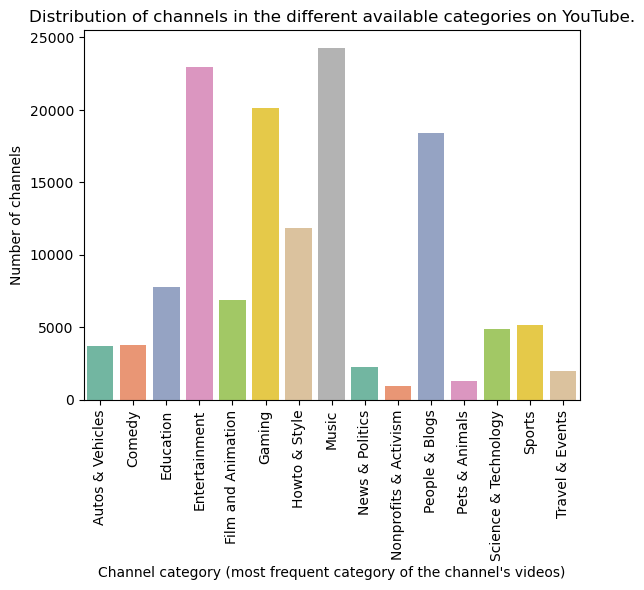

In [ ]:
channels_by_category_filepath = dataset_root_path + "../generated_data/channel_count_per_category.csv"

try:  # try to read data from file
    channels_per_category = pd.read_csv(channels_by_category_filepath)
    print("Loaded data from file")
except FileNotFoundError:  # if file does not exist, generate it and save
    channels_per_category = df_channels_clean.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
    channels_per_category.to_csv(channels_by_category_filepath, index=False)

display(channels_per_category)


ax = sns.barplot(x="category_cc", y="number_of_channels", data=channels_per_category,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of channels in the different available categories on YouTube.")
plt.xlabel("Channel category (most frequent category of the channel's videos)")
plt.ylabel("Number of channels")
plt.show()

 
One can see that the number of channels corresponding to News&Politics category is very low ! This category is even one of the smallest. What about the number of corresponding videos ?

#### 1. Distribution of categories for the channels

In [ ]:
#distribution categories of videos over the whole (cleaned) dataset per chunck

# Define a function that processes a single chunk
def count_videos_by_category(chunk):
    
    # Count videos in each category within the chunk
    category_counts = chunk['categories'].value_counts().to_frame().T  # Get counts and transpose for one-row DataFrame
    category_counts.columns.name = None  # Remove column name for easy concatenation
    return category_counts

videos_by_category_filepath = dataset_root_path + "../generated_data/video_count_by_category.csv"

try:  # try to read the data from file
    videos_per_category_counts_total = pd.read_csv(videos_by_category_filepath)
    print("Data read from file")
except FileNotFoundError:  # otherwise, generate it and save

    # Apply the function to all chunks and get the results concatenated
    videos_per_category_counts_per_chunk = dp.run_simple_function_on_chunks_concat(
        videos_in_chunks_clean(chunksize=100000), 
        count_videos_by_category,
        print_time=(100000, 72924794)
        )

    # Sum the counts across all chunks to get the total count of videos per category
    videos_per_category_counts_total = videos_per_category_counts_per_chunk.sum().to_frame(name='total_count').reset_index()
    videos_per_category_counts_total.columns = ['category', 'total_count']

    videos_per_category_counts_total.to_csv(videos_by_category_filepath,)  # save the created dataframe so we don't have to generate it again


# Display the final distribution
print(videos_per_category_counts_total)

ax = sns.barplot(x="category", y="total_count", hue='category', legend=False, data=videos_per_category_counts_total, palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of videos in the different available categories on YouTube.")
plt.xlabel("Video category")
plt.ylabel("Number of videos")
plt.show()

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
4.269 secs per chunk on average. Meaning  51.817 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
4.371 secs per chunk on average. Meaning  52.983 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
4.175 secs per chunk on average. Meaning  50.532 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
4.064 secs per chunk on average. Meaning  49.119 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.827 secs per chunk on average. Meaning  46.197 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.760 secs per chunk on average. Meaning  45.319 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.690 secs per chunk

KeyboardInterrupt: 

### Analysis 

It is apparent that there are fewer News & Politics channels compared to other categories. However, the proportion of News & Politics videos is much higher. This suggests that News & Politics followers are relatively active in posting content.

Therefore, studying News & Politics videos seems to be a worthwhile pursuit, with a large enough number of videos available, even though it will naturally not fully represent the broader YouTube community. 




In [ ]:
# delete the datasets, as we don't need them anymore

#del videos_per_category_counts_total
#del channels_per_category

## Filtering the datasets to our needs - News & Politics

### Filtering **videos** by category 'News & Politics'

In [3]:
# filter the video dataframe to only include videos from n&p category

videos_in_news_pol_filepath = dataset_root_path + "../generated_data/videos_in_news_pol.csv"

if os.path.isfile(videos_in_news_pol_filepath):  # if the file already exists
    print("File already exists, no need to generate again.\nDelete or rename the existing file in order to regenerate it.")
else:  # if not, generate the file. The data is directly saved to a new dataframe, 
       # because it would be to big to load in memory at once
    dp.run_simple_function_on_chunks_save_csv(videos_in_chunks_clean(chunksize=100000),
                                              lambda x: x[x.categories == "News & Politics"], 
                                              filename=videos_in_news_pol_filepath,
                                              index=False,
                                              overwrite=False,  # will not overwrite existing files
                                              every=15,  # will save to the csv every 15 chunks
                                              print_time=(100000, 72924794), video=True)
    
# a new filtered file is saved, this dataframe will be used from now on.

File already exists, no need to generate again.
Delete or rename the existing file in order to regenerate it.


In [6]:
# load the (large) csv file that was just written, containing the videos in news and politics, in chunks, 
# and print the head of the first chunk and the shape of each chunk (this is just to show that it worked)

# print("News and politics videos:\n")

# total_length = 0
# for i, chunk in enumerate(pd.read_csv(dataset_root_path + "/../generated_data/videos_in_news_pol.csv", chunksize=100000)):
    
#     if i == 0:
#         print(f"Head of chunk 0: ")
#         print(chunk[chunk.channel_id == "UCupvZG-5ko_eiXAupbDfxWw"])

#         display(chunk.head())
#         print("The shapes of all chunks:")
#     print(f"Shape of chunk number {i}: {chunk.shape}")
#     total_length += chunk.shape[0]

# print(f"In total {total_length} rows, which takes up {i+1} chunks.")
# del chunk

# print(f"{gc.collect()} garbages collected.")

## Extracting just the *Video IDs* of the Videos in News & Politics in as a Series
(In order to be able to use this without loading the entire Videos in News & Politics DataFrame)

In [8]:
videos_news_pol_display_ids_filepath = dataset_root_path + "../generated_data/videos_news_pol_display_ids.csv"

try:
    df_videos_news_pol_display_ids = pd.read_csv(videos_news_pol_display_ids_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_videos_news_pol_display_ids = dp.run_simple_function_on_chunks_concat(pd.read_csv(videos_in_news_pol_filepath, chunksize=100000, usecols=['display_id']),
                                                                                 fct = lambda df: df['display_id'],
                                                                                 print_time=True,
                                                                                 save=videos_news_pol_display_ids_filepath.replace('.csv', '')
                                                                                 )
    df_videos_news_pol_display_ids.to_csv(videos_news_pol_display_ids_filepath, index=False)

Read data from file


### Filtering **channels** by category News & Politics

In [8]:
#filter channels dataset to only include n&p

# Note: because the channel dataset is much smaller than the video dataset, we don't need to worry about chunks here
# Also, the results can be saved in a single file without a problem.

channels_news_pol_filepath = dataset_root_path + "../generated_data/channels_in_news_pol.csv"

try:
    df_channels_news_pol = pd.read_csv(channels_news_pol_filepath)
    print("Read data from file")
except FileNotFoundError:
    df_channels_news_pol = df_channels_clean[df_channels_clean.category_cc == "News & Politics"]
    df_channels_news_pol.to_csv(channels_news_pol_filepath, index=False)

#this file will be used from now on

Read data from file


In [7]:
display(df_channels_news_pol.head())
display(df_channels_news_pol.shape)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.087
1,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.087
2,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.087
3,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.087
4,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.087


(2263, 8)

### Checking whether all videos in News and Politics are also uploaded by a channel in that category

In [8]:
# check if all videos we found in news&pol are also published by a channel in category n&p

# videos_news_pol__channel_not_news_pol_filepath = dataset_root_path + "../generated_data/videos_in_news_pol__channel_not_in_news_pol.csv"


# try:
#     df_videos_news_pol__channel_not_news_pol = pd.read_csv(videos_news_pol__channel_not_news_pol_filepath)
#     print("Read data from file")
# except FileNotFoundError:
#     # go through the large file of news and politics videos in chunks, 
#     # and extract all videos which were not uploaded by a News & Politics channel

#     df_videos_news_pol__channel_not_news_pol = dp.run_simple_function_on_chunks_concat(
#         reader=pd.read_csv(dataset_root_path + "../generated_data/videos_in_news_pol.csv", chunksize=100000),
#         fct=lambda chunk: chunk[np.logical_not(chunk.channel_id.isin(df_channels_news_pol.channel))],
#         print_time=True
#         )

#     # save the resuls to a csv
#     df_videos_news_pol__channel_not_news_pol.to_csv(videos_news_pol__channel_not_news_pol_filepath, index=False)

        
# display(df_videos_news_pol__channel_not_news_pol.head())
# display(df_videos_news_pol__channel_not_news_pol.shape)



**We see that indeed, not all videos in the news and politics category belong to a channel in this category!** (541172 such videos, out of 7551328 in total in News & Politics, see output a few cells above)
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channel, but not all.

In the paper about the YouNiverse dataset, the authors say that the channel category is actually the "most frequent category". We believe that the video categories are the most relevant, as they are the 'true' categories of the content.

In [9]:
# del df_videos_news_pol__channel_not_news_pol
# print(gc.collect())

### Filtering the N&P videos by a list of channels

In [9]:
# define variables for the channel ids of CNN, ABC, BBC, Al Jazeera English and Fox
channel_id_cnn = "UCupvZG-5ko_eiXAupbDfxWw"  # CNN
channel_id_abc = "UCBi2mrWuNuyYy4gbM6fU18Q"  # ABC News
channel_id_bbc = "UC16niRr50-MSBwiO3YDb3RA"  # BBC News
channel_id_aje = "UCNye-wNBqNL5ZzHSJj3l8Bg"  # Al Jazeera English
channel_id_fox = "UCXIJgqnII2ZOINSWNOGFThA"  # Fox News

selected_channel_ids = [channel_id_cnn,
                        channel_id_abc,
                        channel_id_bbc,
                        channel_id_aje,
                        channel_id_fox]


In [11]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, ABC News, BBC News, Al Jazeera English and Fox News)

# videos_news_pol_manual_selection_filepath = dataset_root_path + "../generated_data/videos_from_news_pol_from_selected_channels.csv"

# try:
#     df_videos_news_pol_manually_selected = pd.read_csv(videos_news_pol_manual_selection_filepath)
#     print("Read data from file")
# except FileNotFoundError:
#     # go through the large file with videos in news and politics, 
#     # and select those videos which are uploaded by one of our selected channels
    
#     df_videos_news_pol_manually_selected = dp.run_simple_function_on_chunks_concat(
#         reader=pd.read_csv(dataset_root_path + "../generated_data/videos_in_news_pol.csv", chunksize=100000), 
#         fct=lambda chunk: chunk[chunk.channel_id.isin(selected_channel_ids)],
#         print_time=False)
    
#     # save the results to a csv
#     df_videos_news_pol_manually_selected.to_csv(videos_news_pol_manual_selection_filepath, index=False)

# display(df_videos_news_pol_manually_selected.head())
# display(df_videos_news_pol_manually_selected.shape)


# #checking if all channels are here and have videos
# channel_ids = df_videos_news_pol_manually_selected.channel_id.unique()
# print(channel_ids)

### Split the selected news & pol **videos** in the five channels

In [10]:
# filter the video dataset to get only videos from each of our selected channels

# define the filepaths for the data
videos_news_pol_cnn_filepath = dataset_root_path + "../generated_data/videos_news_pol_cnn.csv"
videos_news_pol_abc_filepath = dataset_root_path + "../generated_data/videos_news_pol_abc.csv"
videos_news_pol_bbc_filepath = dataset_root_path + "../generated_data/videos_news_pol_bbc.csv"
videos_news_pol_aje_filepath = dataset_root_path + "../generated_data/videos_news_pol_aje.csv"
videos_news_pol_fox_filepath = dataset_root_path + "../generated_data/videos_news_pol_fox.csv"

# for each of the 5 channels...
# CNN
try:  # ... try to load the data from file
    df_videos_news_pol_cnn = pd.read_csv(videos_news_pol_cnn_filepath)
    print("Data read from file")
except FileNotFoundError:  # otherwise, generate it and save
    df_videos_news_pol_cnn = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_cnn]
    df_videos_news_pol_cnn.to_csv(videos_news_pol_cnn_filepath, index=False)

# ABC News
try:
    df_videos_news_pol_abc = pd.read_csv(videos_news_pol_abc_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_abc = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_abc]
    df_videos_news_pol_abc.to_csv(videos_news_pol_abc_filepath, index=False)
    
# BBC News
try:
    df_videos_news_pol_bbc = pd.read_csv(videos_news_pol_bbc_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_bbc = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_bbc]
    df_videos_news_pol_bbc.to_csv(videos_news_pol_bbc_filepath, index=False)

# Al Jazeera English
try:
    df_videos_news_pol_aje = pd.read_csv(videos_news_pol_aje_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_aje = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_aje]
    df_videos_news_pol_aje.to_csv(videos_news_pol_aje_filepath, index=False)

# Fox News
try:
    df_videos_news_pol_fox = pd.read_csv(videos_news_pol_fox_filepath)
    print("Data read from file")
except FileNotFoundError:
    df_videos_news_pol_fox = df_videos_news_pol_manually_selected.loc[
        df_videos_news_pol_manually_selected.channel_id == channel_id_fox]
    df_videos_news_pol_fox.to_csv(videos_news_pol_fox_filepath, index=False)

Data read from file
Data read from file
Data read from file
Data read from file
Data read from file


### Filtering **comments** from all n&p videos

In [8]:
# get comments on all (n&p) videos from our selected channels

comments_news_pol_videos_filepath = dataset_root_path + "../generated_data/comments_news_pol_videos.csv"

if os.path.isfile(comments_news_pol_videos_filepath):
    print("File already exists, no need to generate again.")
else:

    # get all the comments made on a video in the News&Pol category
    dp.run_simple_function_on_chunks_save_csv(
        comments_in_chunks(chunksize=1000000), 
        lambda comment_df: comment_df.loc[comment_df['video_id'].isin(df_videos_news_pol_display_ids.display_id)],
        comments_news_pol_videos_filepath,
        index=False,
        every=30,
        print_time=(1000000, 8600000000),)


File already exists, no need to generate again.


### Filtering **comments** of the main channels using n&p video ids obtained above

In [8]:
# # get comments on (n&p) videos from our selected channels using the ids from filtered video dataset from the selected channels
# # Check if all 5 channels are in the video dataset before filtering

# comments_news_pol_selected_channels_filepath = dataset_root_path + "../generated_data/comments_news_pol_selected_channels.csv"

# try:
#     df_comments_news_pol_manually_selected = pd.read_csv(comments_news_pol_selected_channels_filepath) 

#     print("Read data from file")
# except FileNotFoundError:

    
#     # get all the comments made on a video uploaded by one of our selected channels
#     df_comments_news_pol_manually_selected = dp.run_simple_function_on_chunks_concat(
#         pd.read_csv(comments_news_pol_videos_filepath, chunksize=1000000),  # only go through news and pol videos 
#         lambda comment_df: comment_df.loc[comment_df['video_id'].isin(df_videos_news_pol_manually_selected.display_id)],
#         print_time=(1000000, 8600000000))
    
#     # merge it with the video data of the selected channels, to get the channel id directly in the comment df
#     df_comments_news_pol_manually_selected = df_comments_news_pol_manually_selected.merge(
#         df_videos_news_pol_manually_selected[["display_id", "channel_id"]], 
#         left_on="video_id", right_on="display_id")
#     # save as csv
#     df_comments_news_pol_manually_selected.to_csv(comments_news_pol_selected_channels_filepath, index=False)

In [ ]:
# display(df_comments_news_pol_manually_selected)
# display(df_comments_news_pol_manually_selected.shape)

# #checking if all channels are here and have videos
# channel_ids = df_comments_news_pol_manually_selected.channel_id.unique()
# print(channel_ids)




### Split the comments into the 5 main channels

In [12]:
# define the file paths for the files for comments from each of the channels

comments_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/comments_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc","bbc", "aje", "fox"]  
    ]

# check if all of the files already exist
if np.all([os.path.isfile(filepath) for filepath in comments_news_pol_selected_channels_filepaths]):
    df_comments_news_pol_cnn = pd.read_csv(comments_news_pol_selected_channels_filepaths[0])
    df_comments_news_pol_abc = pd.read_csv(comments_news_pol_selected_channels_filepaths[1])
    df_comments_news_pol_bbc = pd.read_csv(comments_news_pol_selected_channels_filepaths[2])
    df_comments_news_pol_aje = pd.read_csv(comments_news_pol_selected_channels_filepaths[3])
    df_comments_news_pol_fox = pd.read_csv(comments_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:
    # group the comments by channel
    df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (df_comments_news_pol_cnn,
     df_comments_news_pol_abc,
     df_comments_news_pol_bbc,
     df_comments_news_pol_aje,
     df_comments_news_pol_fox) = (df_comments_news_pol_manually_selected_grouped.get_group(channel_id ) 
                                  for channel_id in [channel_id_cnn,
                                                     channel_id_abc,
                                                     channel_id_bbc,
                                                     channel_id_aje,
                                                     channel_id_fox])
    
    # save the new dfs to csv
    df_comments_news_pol_cnn.to_csv(comments_news_pol_selected_channels_filepaths[0], index=False)
    df_comments_news_pol_abc.to_csv(comments_news_pol_selected_channels_filepaths[1], index=False)
    df_comments_news_pol_bbc.to_csv(comments_news_pol_selected_channels_filepaths[2], index=False)
    df_comments_news_pol_aje.to_csv(comments_news_pol_selected_channels_filepaths[3], index=False)
    df_comments_news_pol_fox.to_csv(comments_news_pol_selected_channels_filepaths[4], index=False)

Read 5 dfs from file


In [17]:
df_comments_news_pol_cnn

,author,video_id,likes,replies,display_id,channel_id
0,269,anah_4blbyU,0,0,anah_4blbyU,UCupvZG-5ko_eiXAupbDfxWw
1,1015,b8Jmjloz9_k,0,0,b8Jmjloz9_k,UCupvZG-5ko_eiXAupbDfxWw
2,1548,-rN17xNnIyM,0,0,-rN17xNnIyM,UCupvZG-5ko_eiXAupbDfxWw
3,1548,-rN17xNnIyM,0,0,-rN17xNnIyM,UCupvZG-5ko_eiXAupbDfxWw
4,1560,OAjEDUYsbsY,0,0,OAjEDUYsbsY,UCupvZG-5ko_eiXAupbDfxWw
...,...,...,...,...,...,...
17977460,576550571,ElSlwPxo7r4,0,0,ElSlwPxo7r4,UCupvZG-5ko_eiXAupbDfxWw
17977461,576550571,iQGVM02jd9Q,82,9,iQGVM02jd9Q,UCupvZG-5ko_eiXAupbDfxWw
17977462,576550571,z71bpXhUmSo,0,0,z71bpXhUmSo,UCupvZG-5ko_eiXAupbDfxWw
17977463,576551701,tyUh_xSjvXQ,0,0,tyUh_xSjvXQ,UCupvZG-5ko_eiXAupbDfxWw


## Initial Analysis

Now that we have new dataframes of comments and videos for the 4 (soon 5) main channels, we explore the plots.

### Total number of subscribers, users (i.e commenters) and comments in the 4 (soon 5) channels

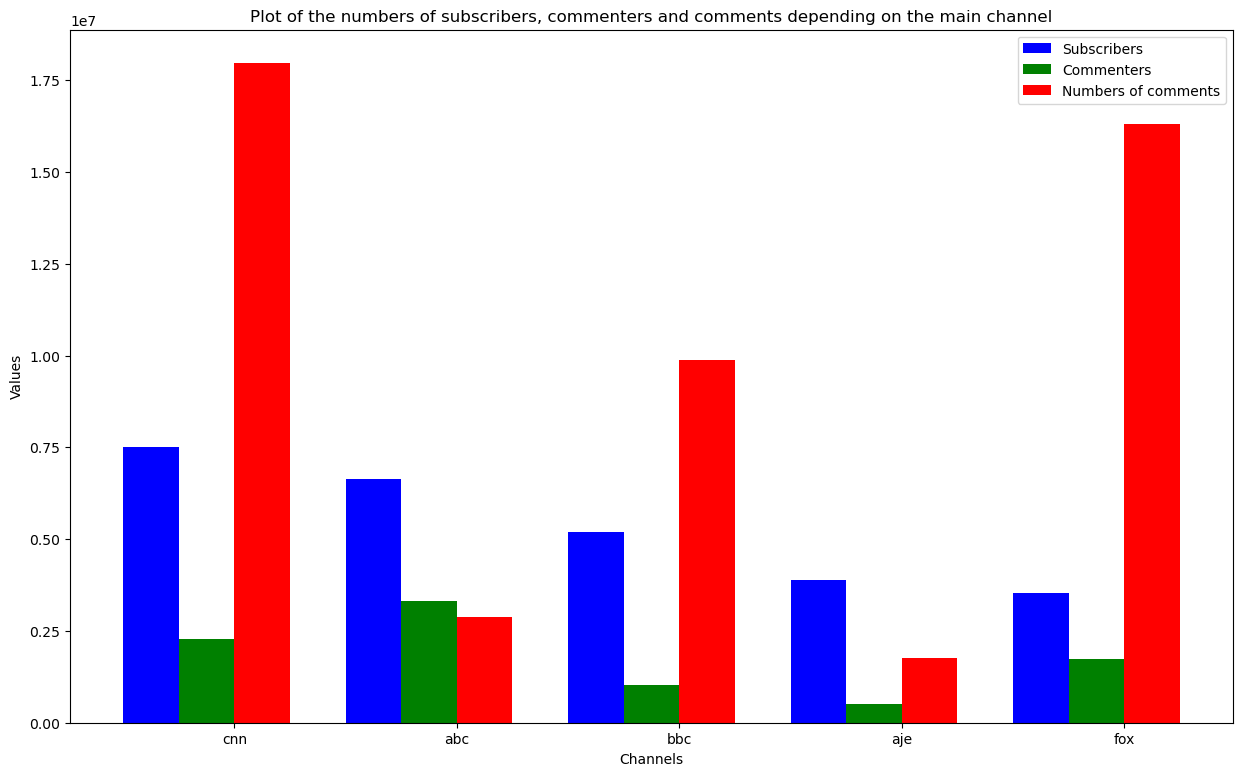

In [13]:
channels = ['cnn', 'abc', 'bbc', 
                'aje', 'fox']
comments = [len(df_comments_news_pol_cnn), 
            len(df_comments_news_pol_bbc), 
            len(df_comments_news_pol_abc), 
            len(df_comments_news_pol_aje), 
            len(df_comments_news_pol_fox)]
subscribers = [df_channels_news_pol[df_channels_news_pol.channel == channel_id_cnn].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_abc].subscribers_cc.values[0],
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_bbc].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_aje].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_fox].subscribers_cc.values[0]]
# Calculate the number of unique authors that commented for each dataframe
commenters = [
    df_comments_news_pol_cnn['author'].nunique(),
    df_comments_news_pol_abc['author'].nunique(),
    df_comments_news_pol_bbc['author'].nunique(),
    df_comments_news_pol_aje['author'].nunique(),
    df_comments_news_pol_fox['author'].nunique()
]

# Bar width
bar_width = 0.25
index = np.arange(len(channels))

# Fig
fig, ax = plt.subplots(figsize=(15, 9))

bar1 = ax.bar(index - bar_width, subscribers, bar_width, label='Subscribers', color='blue')
bar2 = ax.bar(index, commenters, bar_width, label='Commenters', color='green')
bar3 = ax.bar(index + bar_width, comments, bar_width, label='Numbers of comments', color='red')

# Labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Values')
ax.set_title('Plot of the numbers of subscribers, commenters and comments depending on the main channel')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(channels)

# Legend display
ax.legend()

plt.show()


### Distribution of comments - How many people comment frequently?

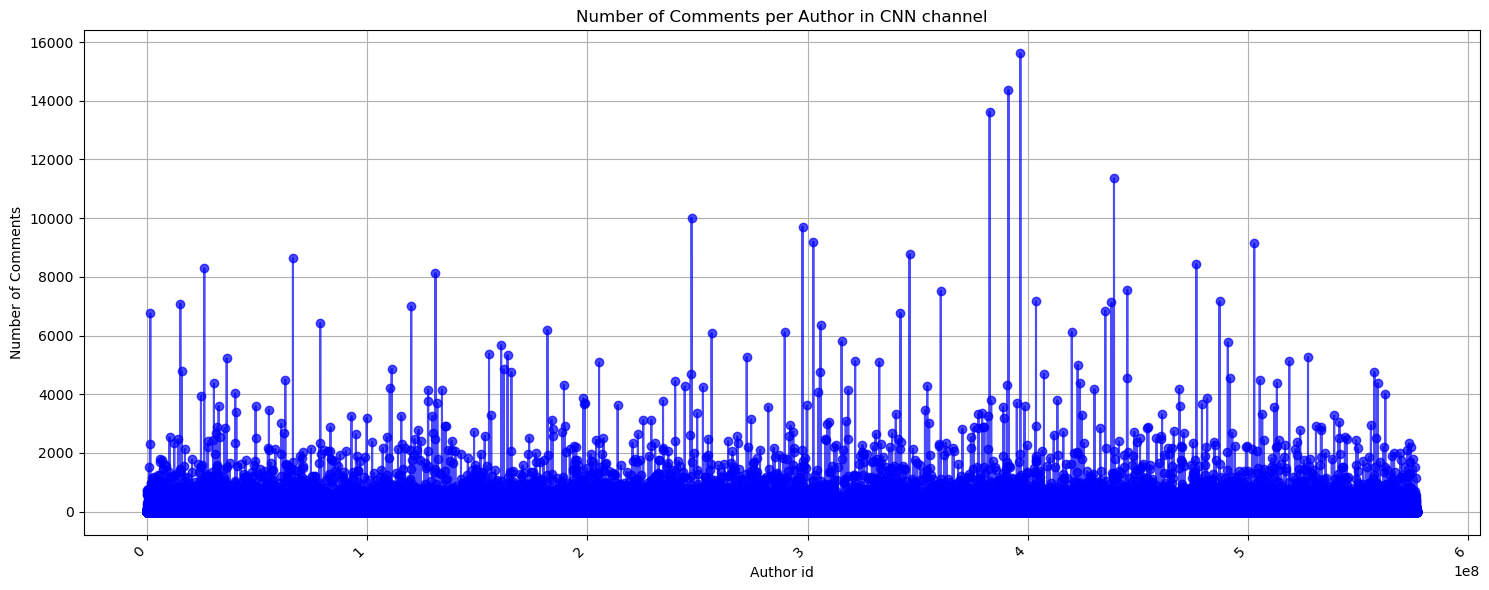

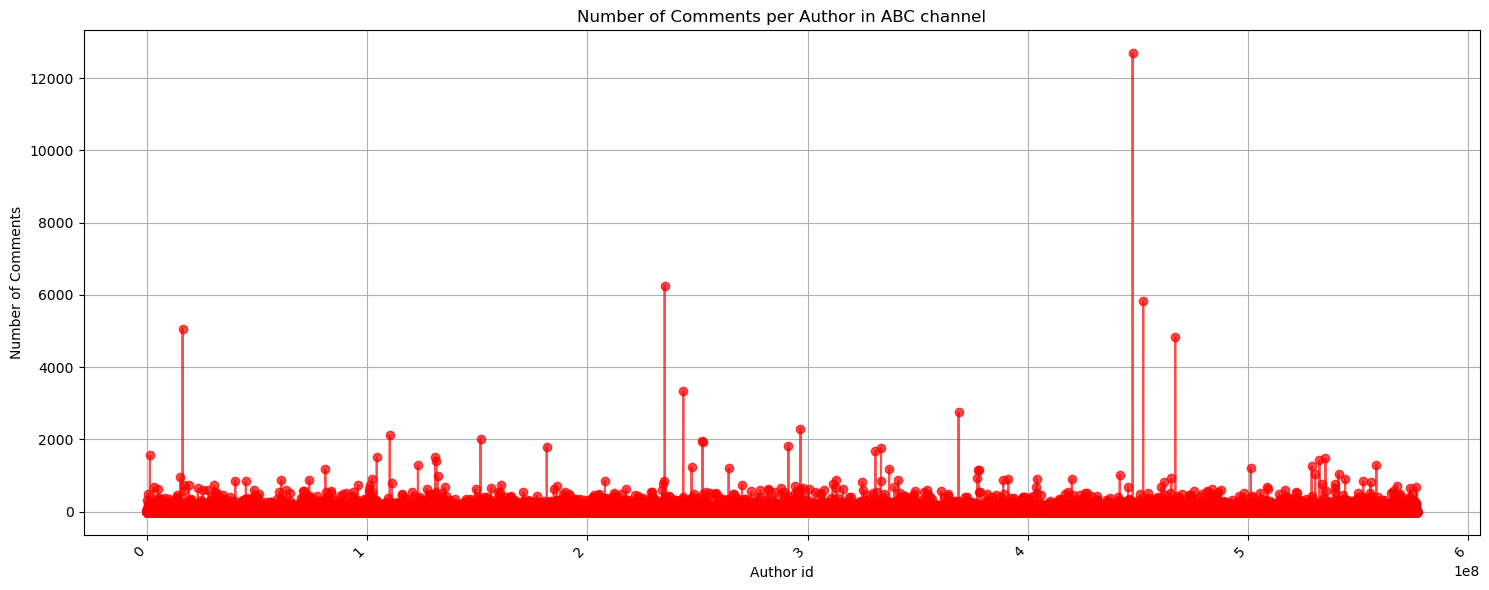

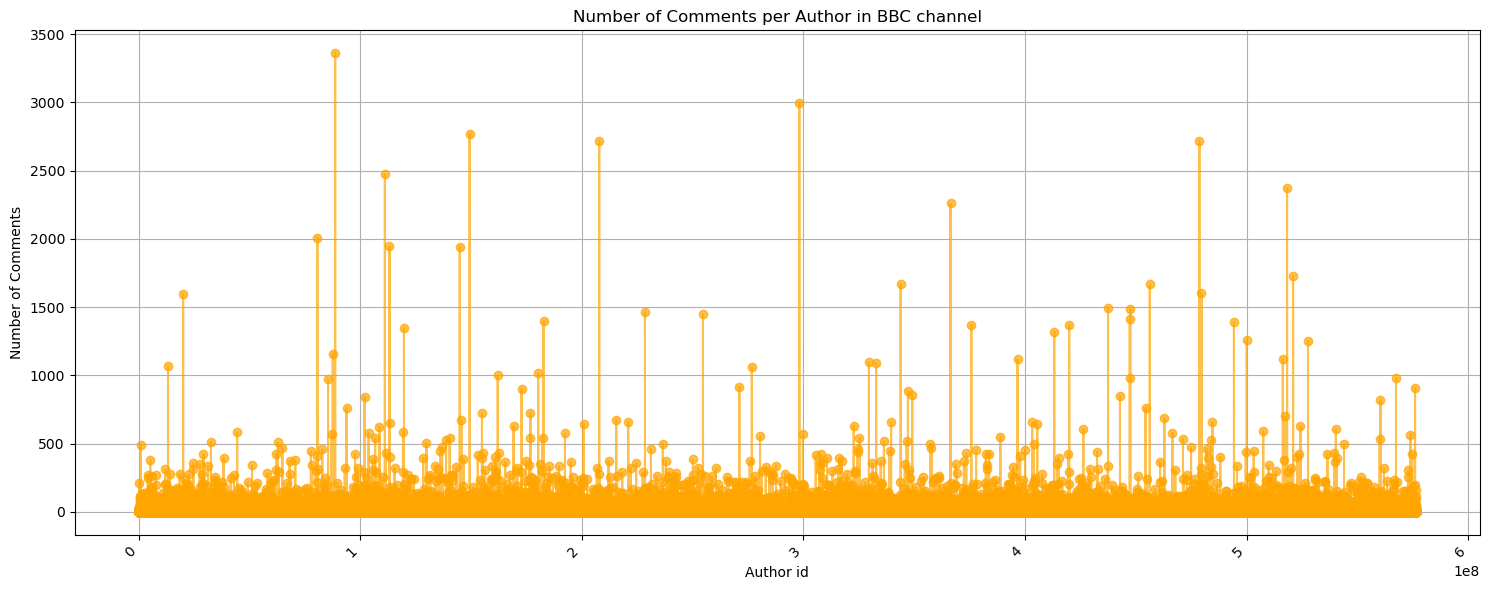

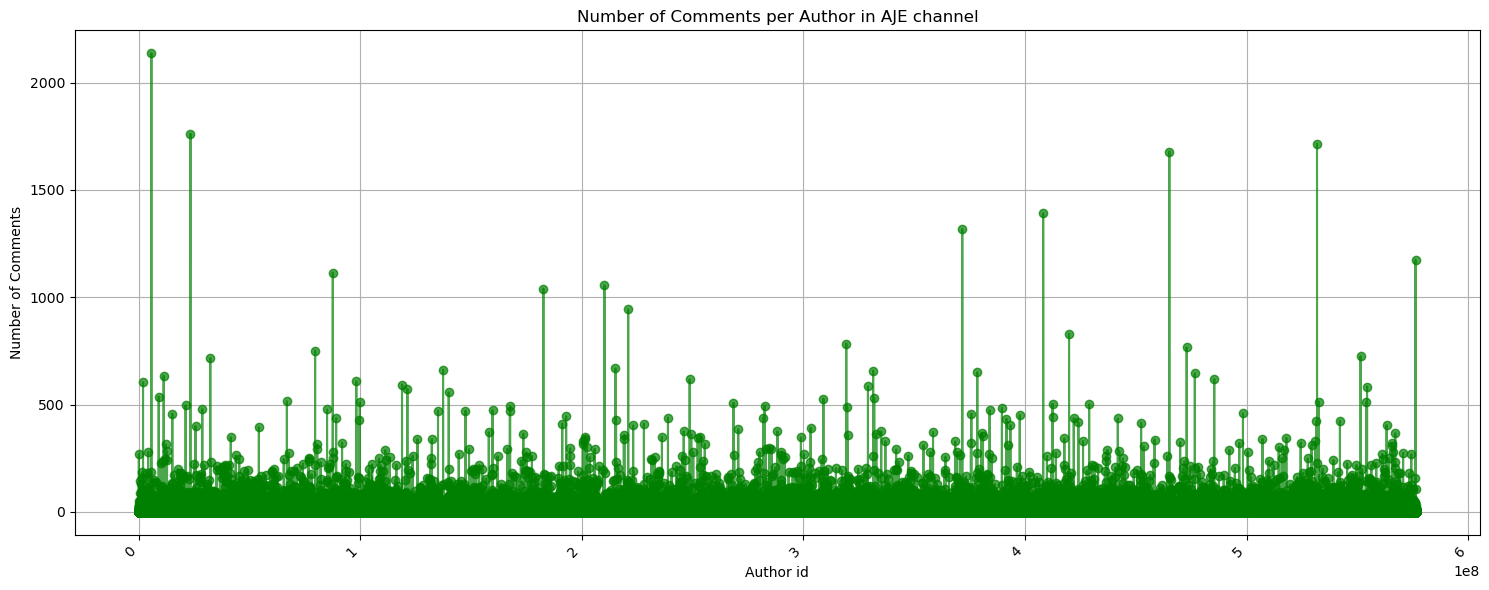

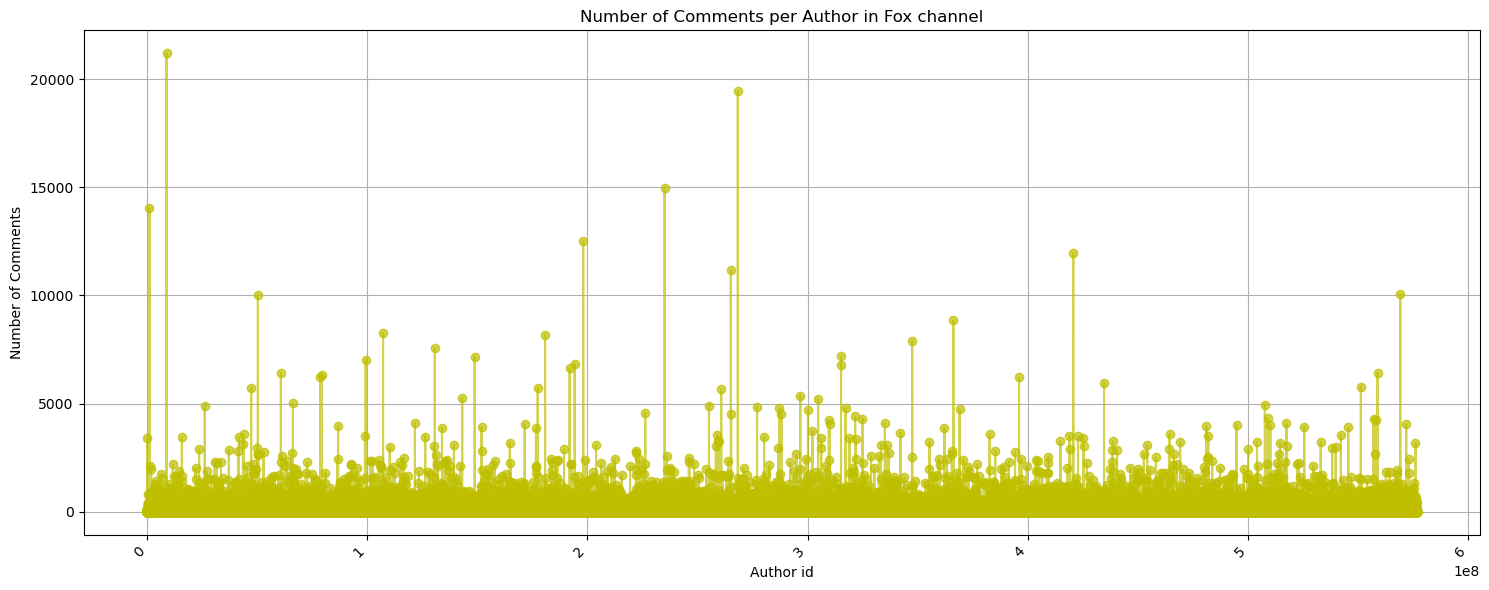

In [14]:
# Grouping by author to get the number of comments per author for each channel
comment_counts_cnn = df_comments_news_pol_cnn.groupby('author').size()
comment_counts_abc = df_comments_news_pol_abc.groupby('author').size()
comment_counts_bbc = df_comments_news_pol_bbc.groupby('author').size()
comment_counts_aje = df_comments_news_pol_aje.groupby('author').size()
comment_counts_fox = df_comments_news_pol_fox.groupby('author').size()

# CNN 
plt.figure(figsize=(15, 6))
plt.plot(comment_counts_cnn.index, comment_counts_cnn, marker='o', color='b', alpha=0.7)  
plt.title('Number of Comments per Author in CNN channel')  
plt.xlabel('Author id') 
plt.ylabel('Number of Comments')  
plt.xticks(rotation=45, ha='right') 
plt.grid(True)  
plt.tight_layout() 
plt.show() 




# ABC 
plt.figure(figsize=(15, 6))
plt.plot(comment_counts_abc.index, comment_counts_abc, marker='o', color='r', alpha=0.7)  
plt.title('Number of Comments per Author in ABC channel')  
plt.xlabel('Author id') 
plt.ylabel('Number of Comments')  
plt.xticks(rotation=45, ha='right') 
plt.grid(True)  
plt.tight_layout() 
plt.show() 

# BBC
plt.figure(figsize=(15, 6))
plt.plot(comment_counts_bbc.index, comment_counts_bbc, marker='o', color='orange', alpha=0.7)  
plt.title('Number of Comments per Author in BBC channel')  
plt.xlabel('Author id') 
plt.ylabel('Number of Comments')  
plt.xticks(rotation=45, ha='right') 
plt.grid(True)  
plt.tight_layout() 
plt.show() 

# AJE
plt.figure(figsize=(15, 6))
plt.plot(comment_counts_aje.index, comment_counts_aje, marker='o', color='g', alpha=0.7)  
plt.title('Number of Comments per Author in AJE channel')  
plt.xlabel('Author id') 
plt.ylabel('Number of Comments')  
plt.xticks(rotation=45, ha='right') 
plt.grid(True)  
plt.tight_layout() 
plt.show() 


# Fox
plt.figure(figsize=(15, 6))
plt.plot(comment_counts_fox.index, comment_counts_fox, marker='o', color='y', alpha=0.7)  
plt.title('Number of Comments per Author in Fox channel')  
plt.xlabel('Author id') 
plt.ylabel('Number of Comments')  
plt.xticks(rotation=45, ha='right') 
plt.grid(True)  
plt.tight_layout() 
plt.show() 


### Analysis 
The distribution of comments per author is extremely broad, with most users writing few comments while some individuals have extraordinarily high comment volumes. Fox News stands out with users who have commented over 20,000 times, while CNN and AJE also have highly active isolated users, albeit with somewhat lower maximal comment values compared to Fox News.

### Comments distribution for the 5 main channels

/tmp/ipykernel_24155/199313359.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  authors_per_bin_cnn.column_cnns = ['Comment Range', 'Number of Authors']


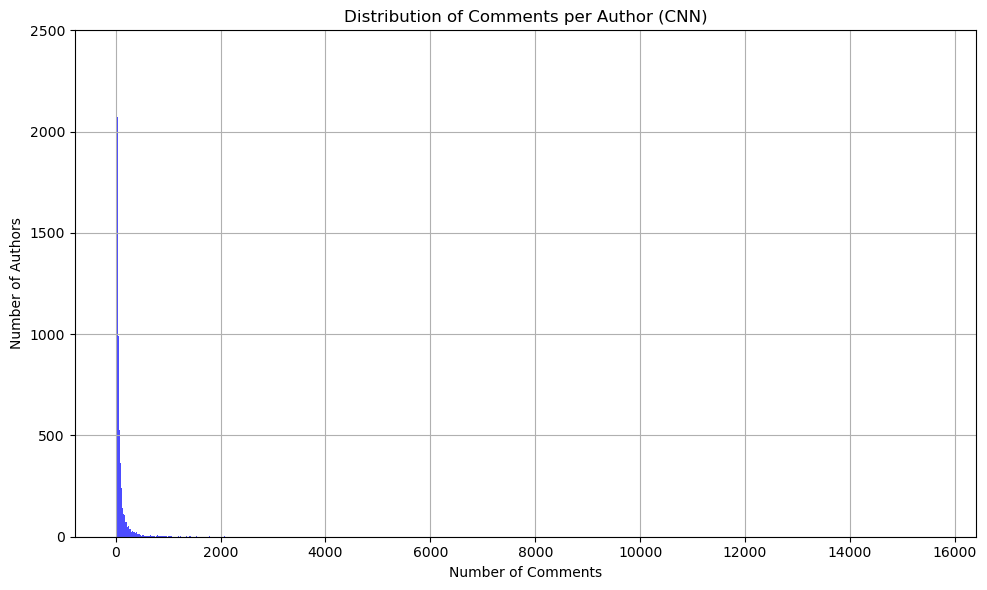

/tmp/ipykernel_24155/199313359.py:32: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  authors_per_bin_abc.column_abcs = ['Comment Range', 'Number of Authors']


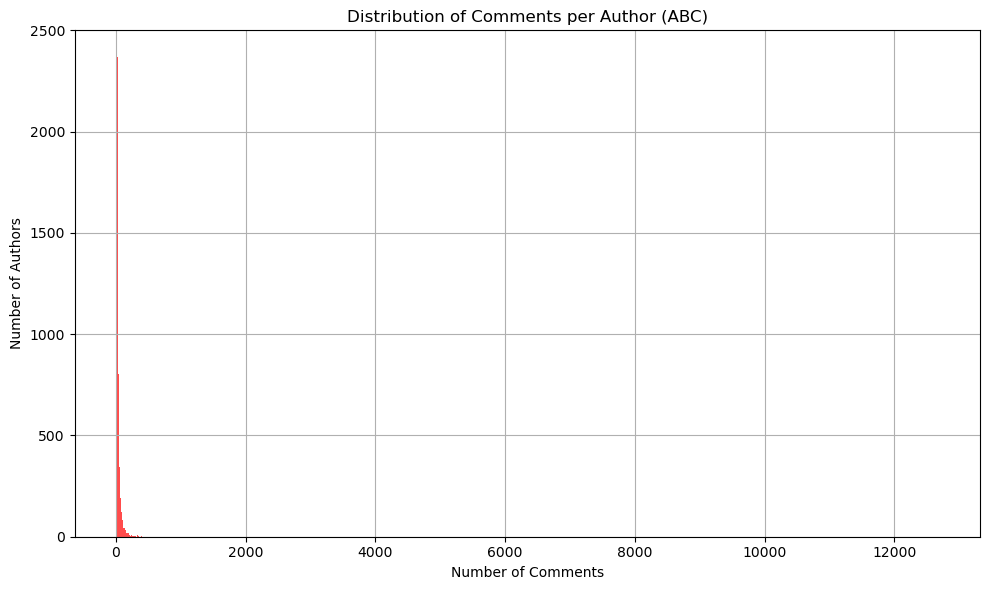

/tmp/ipykernel_24155/199313359.py:53: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  authors_per_bin_bbc.column_bbcs = ['Comment Range', 'Number of Authors']


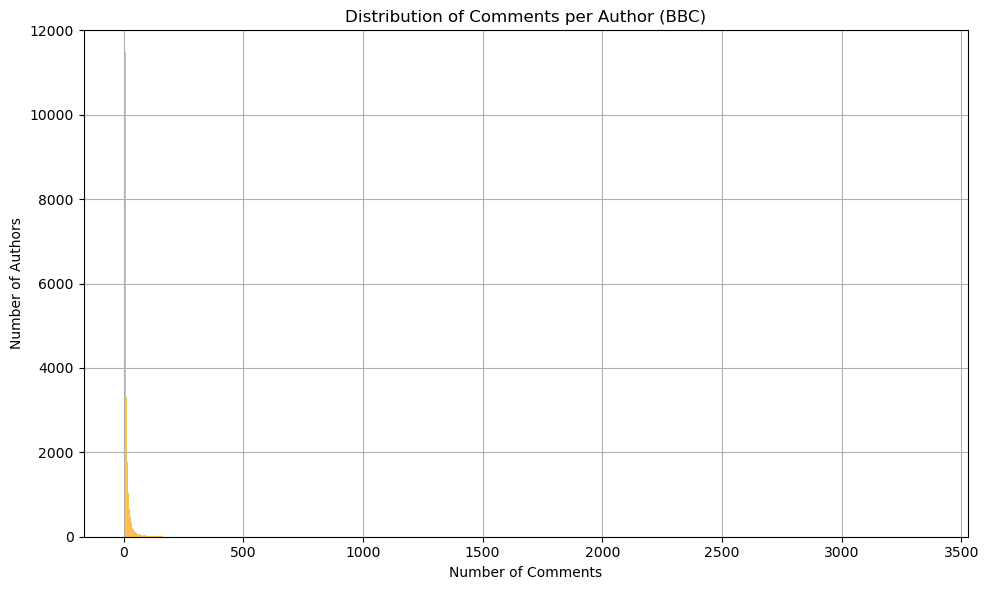

/tmp/ipykernel_24155/199313359.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  authors_per_bin_aje.column_ajes = ['Comment Range', 'Number of Authors']


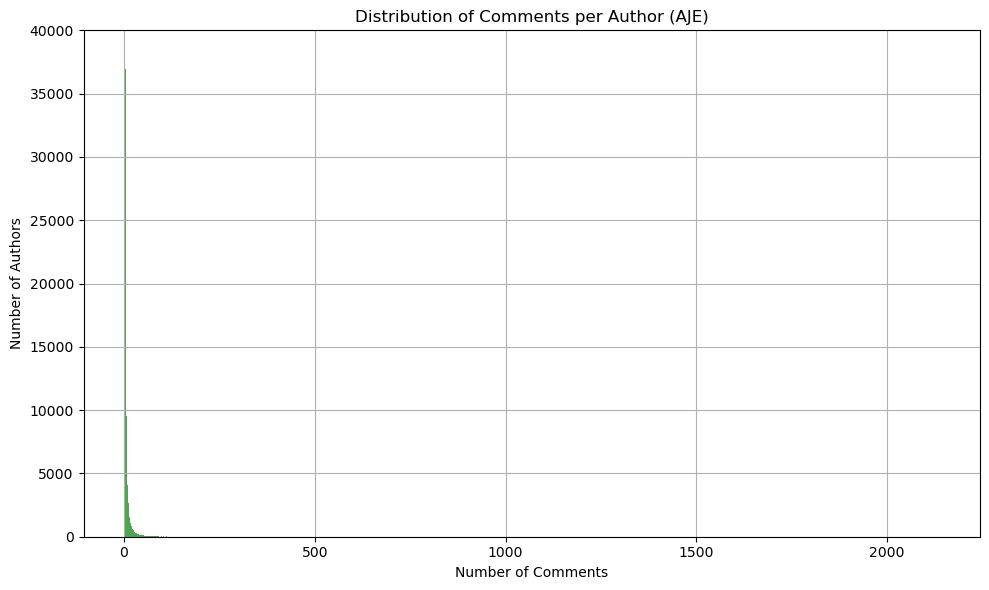

/tmp/ipykernel_24155/199313359.py:95: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  authors_per_bin_fox.column_foxs = ['Comment Range', 'Number of Authors']


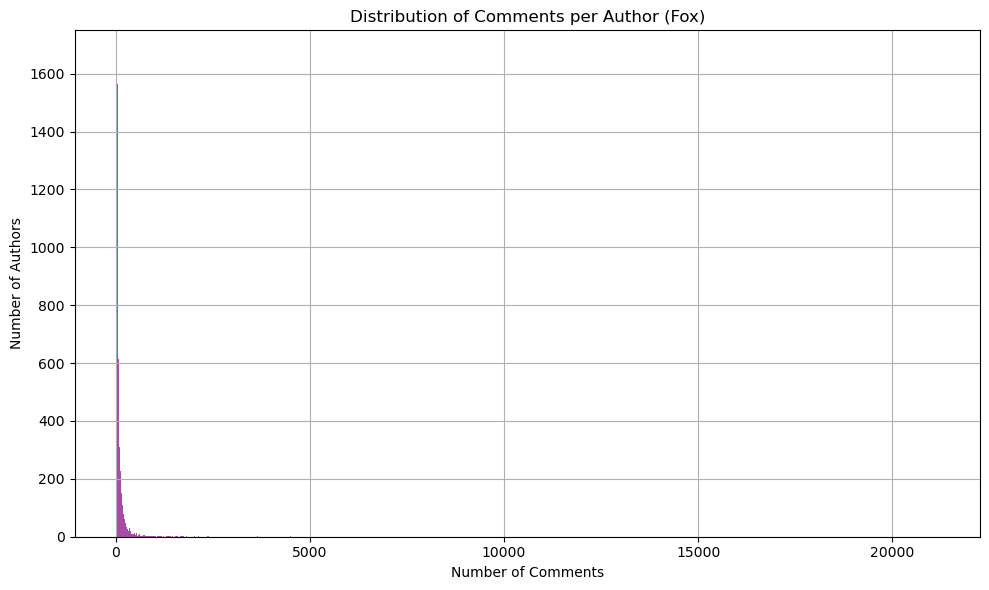

In [11]:

#CNN
#bins = range(0, comment_counts_cnn.max() + 10, 10)  # Create bins from 0 to max comments in steps of 10
bins = np.logspace(np.log10(1), np.log10(comment_counts_cnn.max()), num=20)
bin_labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Labels like '0-10', '10-20', etc.
# Use pd.cut to bin the comment counts 
comment_counts_binned_cnn = pd.cut(comment_counts_cnn, bins=bins, labels=bin_labels, right=False)
authors_per_bin_cnn = comment_counts_binned_cnn.value_counts().sort_index()
authors_per_bin_cnn = authors_per_bin_cnn.reset_index()
authors_per_bin_cnn.column_cnns = ['Comment Range', 'Number of Authors']


# Plot the histogram for CNN
plt.figure(figsize=(10,6))
plt.hist(comment_counts_cnn, bins=range(1, comment_counts_cnn.max() + 1), alpha=0.7, color = 'blue')
plt.title('Distribution of Comments per Author (CNN)')
plt.xlabel('Number of Comments')
plt.ylim(0,2500)
plt.ylabel('Number of Authors')
plt.grid(True)
plt.tight_layout()
plt.show() 



#ABC
bins = range(0, comment_counts_abc.max() + 10, 10)  # Create bins from 0 to max comments in steps of 10
bin_labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Labels like '0-10', '10-20', etc.
# Use pd.cut to bin the comment counts 
comment_counts_binned_abc = pd.cut(comment_counts_abc, bins=bins, labels=bin_labels, right=False)
authors_per_bin_abc = comment_counts_binned_abc.value_counts().sort_index()
authors_per_bin_abc = authors_per_bin_abc.reset_index()
authors_per_bin_abc.column_abcs = ['Comment Range', 'Number of Authors']


# Plot the histogram for ABC
plt.figure(figsize=(10,6))
plt.hist(comment_counts_abc, bins=range(1, comment_counts_abc.max() + 1), alpha=0.7, color= 'red')
plt.title('Distribution of Comments per Author (ABC)')
plt.xlabel('Number of Comments')
plt.ylim(0,2500)
plt.ylabel('Number of Authors')
plt.grid(True)
plt.tight_layout()
plt.show() 

#BBC
bins = range(0, comment_counts_bbc.max() + 10, 10)  # Create bins from 0 to max comments in steps of 10
bin_labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Labels like '0-10', '10-20', etc.
# Use pd.cut to bin the comment counts 
comment_counts_binned_bbc = pd.cut(comment_counts_bbc, bins=bins, labels=bin_labels, right=False)
authors_per_bin_bbc = comment_counts_binned_cnn.value_counts().sort_index()
authors_per_bin_bbc = authors_per_bin_cnn.reset_index()
authors_per_bin_bbc.column_bbcs = ['Comment Range', 'Number of Authors']


# Plot the histogram for BBC
plt.figure(figsize=(10,6))
plt.hist(comment_counts_bbc, bins=range(1, comment_counts_bbc.max() + 1), alpha=0.7, color = 'orange')
plt.title('Distribution of Comments per Author (BBC)')
plt.xlabel('Number of Comments')
plt.ylim(0,12000)
plt.ylabel('Number of Authors')
plt.grid(True)
plt.tight_layout()
plt.show() 

#AJE
bins = range(0, comment_counts_aje.max() + 10, 10)  # Create bins from 0 to max comments in steps of 10
bin_labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Labels like '0-10', '10-20', etc.
# Use pd.cut to bin the comment counts 
comment_counts_binned_aje = pd.cut(comment_counts_aje, bins=bins, labels=bin_labels, right=False)
authors_per_bin_aje = comment_counts_binned_aje.value_counts().sort_index()
authors_per_bin_aje = authors_per_bin_aje.reset_index()
authors_per_bin_aje.column_ajes = ['Comment Range', 'Number of Authors']


# Plot the histogram for AJE
plt.figure(figsize=(10,6))
plt.hist(comment_counts_aje, bins=range(1, comment_counts_aje.max() + 1), alpha=0.7, color = 'green')
plt.title('Distribution of Comments per Author (AJE)')
plt.xlabel('Number of Comments')
plt.ylim(0,40000)
plt.ylabel('Number of Authors')
plt.grid(True)
plt.tight_layout()
plt.show() 

#Fox
bins = range(0, comment_counts_fox.max() + 10, 10)  # Create bins from 0 to max comments in steps of 10
bin_labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Labels like '0-10', '10-20', etc.
# Use pd.cut to bin the comment counts 
comment_counts_binned_fox = pd.cut(comment_counts_cnn, bins=bins, labels=bin_labels, right=False)
authors_per_bin_fox = comment_counts_binned_fox.value_counts().sort_index()
authors_per_bin_fox = authors_per_bin_fox.reset_index()
authors_per_bin_fox.column_foxs = ['Comment Range', 'Number of Authors']


# Plot the histogram for Fox
plt.figure(figsize=(10,6))
plt.hist(comment_counts_fox, bins=range(1, comment_counts_fox.max() + 1), alpha=0.7, color = 'purple')
plt.title('Distribution of Comments per Author (Fox)')
plt.xlabel('Number of Comments')
plt.ylim(0,1750)
plt.ylabel('Number of Authors')
plt.grid(True)
plt.tight_layout()
plt.show() 



## Analysis

All the channels exhibit highly skewed distributions, with the key distinction being the range of comment counts across each channel. AJE seems to be the channel with the most users that write a small numbers of comments, and Fox the lowest of such commenters. What stands out in these distributions is that they all have a "long tail", meaning that there exist users posting significantly more comments than the very large majority of users. This suggests that the more active authors can be identified as distinct clusters based on their comment volume.
One can see that Fox users tend to be way more active then others !!


For better visualization, we will plot in log scale :

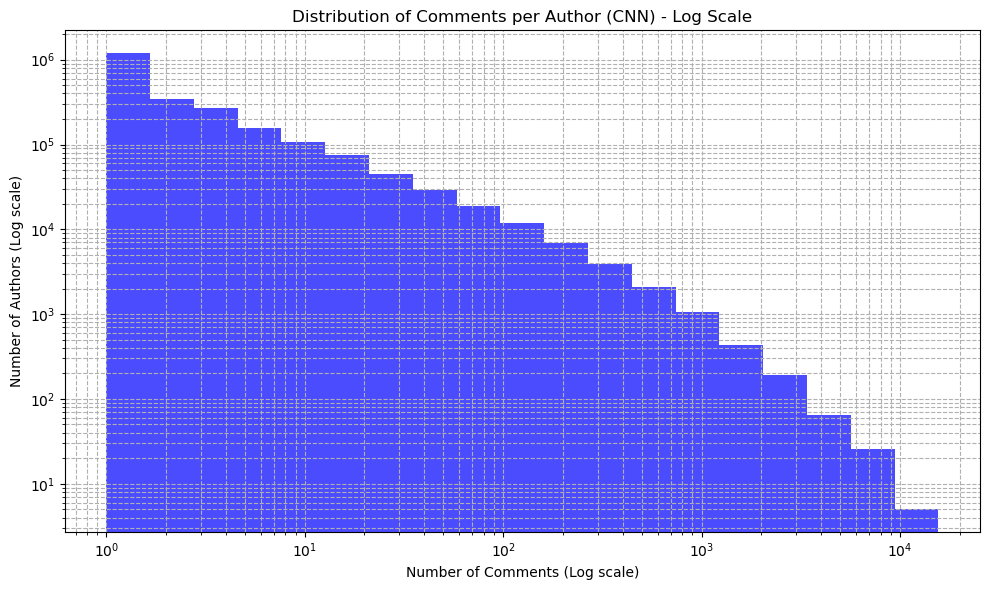

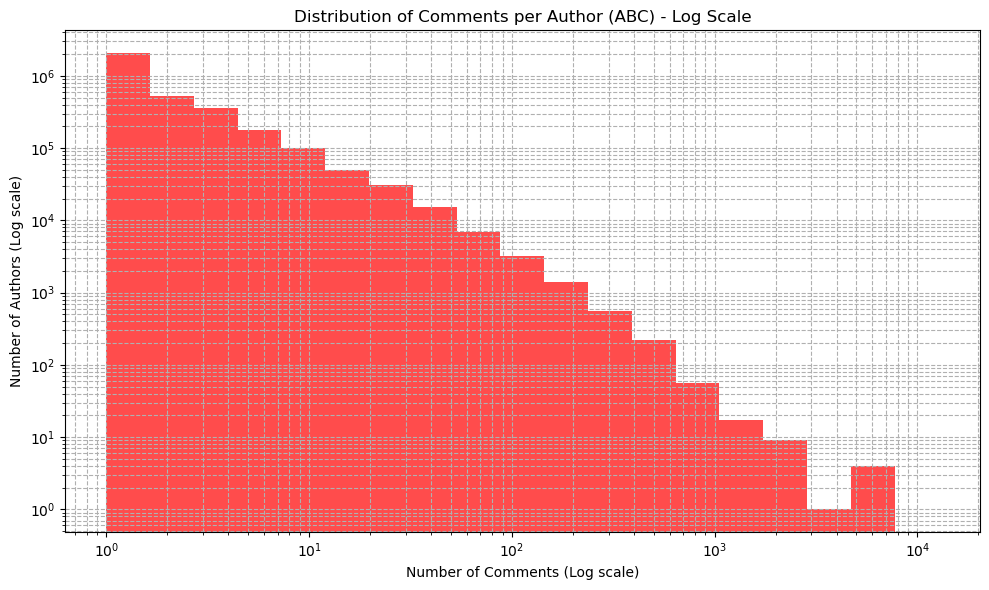

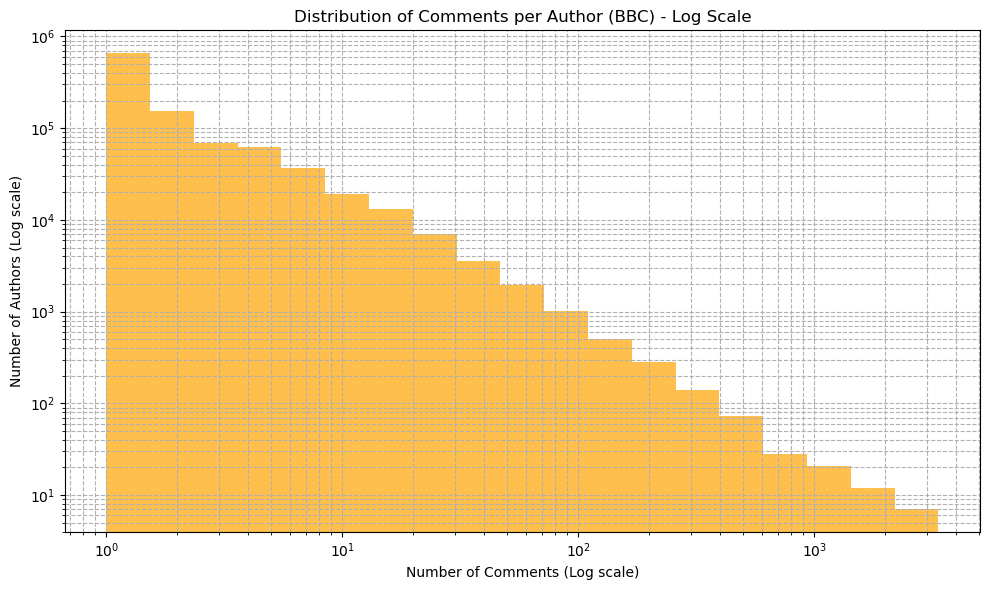

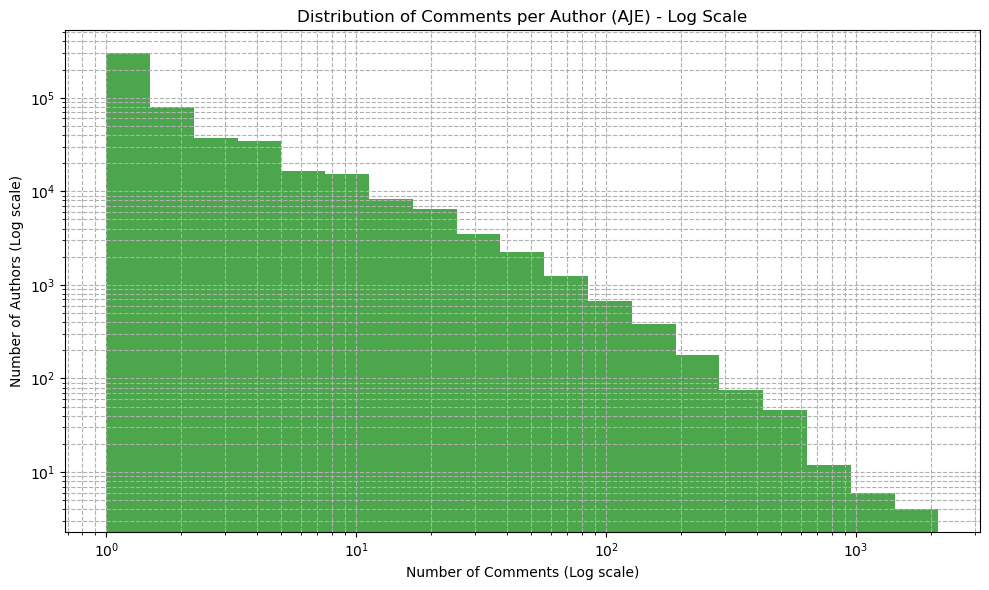

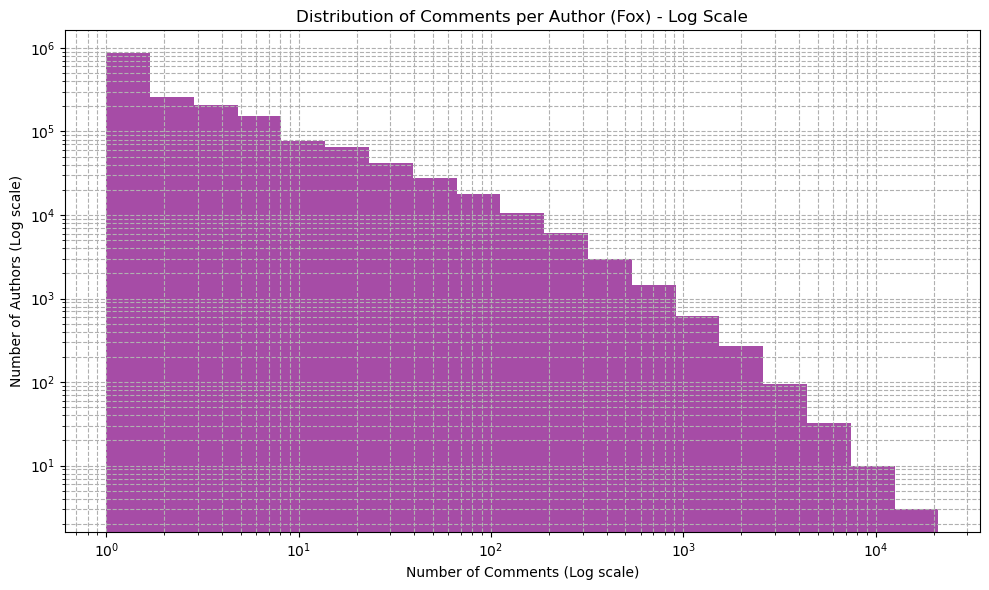

In [12]:
#CNN
#log for both x and y
log_bins = np.logspace(np.log10(1), np.log10(comment_counts_cnn.max()), num=20)  
bin_labels = [f'{int(log_bins[i])}-{int(log_bins[i+1])}' for i in range(len(log_bins)-1)] 

comment_counts_binned_cnn = pd.cut(comment_counts_cnn, bins=log_bins, labels=bin_labels, right=False)

authors_per_bin_cnn = comment_counts_binned_cnn.value_counts().sort_index()
authors_per_bin_cnn = authors_per_bin_cnn.reset_index()
authors_per_bin_cnn.columns = ['Comment Range', 'Number of Authors']

plt.figure(figsize=(10,6))
plt.hist(comment_counts_cnn, bins=log_bins, alpha=0.7, color='blue')
plt.xscale('log')  
plt.yscale('log')  
plt.title('Distribution of Comments per Author (CNN) - Log Scale')
plt.xlabel('Number of Comments (Log scale)')
plt.ylabel('Number of Authors (Log scale)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()




#ABC
#log for both x and y
log_bins = np.logspace(np.log10(1), np.log10(comment_counts_abc.max()), num=20)  
bin_labels = [f'{int(log_bins[i])}-{int(log_bins[i+1])}' for i in range(len(log_bins)-1)] 

comment_counts_binned_abc = pd.cut(comment_counts_abc, bins=log_bins, labels=bin_labels, right=False)

authors_per_bin_abc = comment_counts_binned_abc.value_counts().sort_index()
authors_per_bin_abc = authors_per_bin_abc.reset_index()
authors_per_bin_abc.columns = ['Comment Range', 'Number of Authors']

plt.figure(figsize=(10,6))
plt.hist(comment_counts_abc, bins=log_bins, alpha=0.7, color='red')
plt.xscale('log')  
plt.yscale('log')  
plt.title('Distribution of Comments per Author (ABC) - Log Scale')
plt.xlabel('Number of Comments (Log scale)')
plt.ylabel('Number of Authors (Log scale)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

#BBC
#log for both x and y
log_bins = np.logspace(np.log10(1), np.log10(comment_counts_bbc.max()), num=20)  
bin_labels = [f'{int(log_bins[i])}-{int(log_bins[i+1])}' for i in range(len(log_bins)-1)] 

comment_counts_binned_bbc = pd.cut(comment_counts_bbc, bins=log_bins, labels=bin_labels, right=False)

authors_per_bin_bbc = comment_counts_binned_bbc.value_counts().sort_index()
authors_per_bin_bbc = authors_per_bin_bbc.reset_index()
authors_per_bin_bbc.columns = ['Comment Range', 'Number of Authors']

plt.figure(figsize=(10,6))
plt.hist(comment_counts_bbc, bins=log_bins, alpha=0.7, color='orange')
plt.xscale('log')  
plt.yscale('log')  
plt.title('Distribution of Comments per Author (BBC) - Log Scale')
plt.xlabel('Number of Comments (Log scale)')
plt.ylabel('Number of Authors (Log scale)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


#AJE
#log for both x and y
log_bins = np.logspace(np.log10(1), np.log10(comment_counts_aje.max()), num=20)  
bin_labels = [f'{int(log_bins[i])}-{int(log_bins[i+1])}' for i in range(len(log_bins)-1)] 

comment_counts_binned_aje = pd.cut(comment_counts_aje, bins=log_bins, labels=bin_labels, right=False)

authors_per_bin_aje = comment_counts_binned_aje.value_counts().sort_index()
authors_per_bin_aje = authors_per_bin_aje.reset_index()
authors_per_bin_aje.columns = ['Comment Range', 'Number of Authors']

plt.figure(figsize=(10,6))
plt.hist(comment_counts_aje, bins=log_bins, alpha=0.7, color='green')
plt.xscale('log')  
plt.yscale('log')  
plt.title('Distribution of Comments per Author (AJE) - Log Scale')
plt.xlabel('Number of Comments (Log scale)')
plt.ylabel('Number of Authors (Log scale)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()



#Fox
#log for both x and y
log_bins = np.logspace(np.log10(1), np.log10(comment_counts_fox.max()), num=20)  
bin_labels = [f'{int(log_bins[i])}-{int(log_bins[i+1])}' for i in range(len(log_bins)-1)] 

comment_counts_binned_fox = pd.cut(comment_counts_fox, bins=log_bins, labels=bin_labels, right=False)

authors_per_bin_fox = comment_counts_binned_fox.value_counts().sort_index()
authors_per_bin_fox = authors_per_bin_fox.reset_index()
authors_per_bin_fox.columns = ['Comment Range', 'Number of Authors']

plt.figure(figsize=(10,6))
plt.hist(comment_counts_fox, bins=log_bins, alpha=0.7, color='purple')
plt.xscale('log')  
plt.yscale('log')  
plt.title('Distribution of Comments per Author (Fox) - Log Scale')
plt.xlabel('Number of Comments (Log scale)')
plt.ylabel('Number of Authors (Log scale)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


These plots seem to indicate that the distribution is a power law, as the lines in the log log plots are (to a varying degree) close to a straight line! Further analysis should be done to prove this.

# Part 2: Defining cluster

Flexible function where you give the threshold of x comment --> first function towards selecting clusters

This part is not done. Will be finished in P3.


In [15]:
#returns df with users_id and total number of comments made in a specific channel
def get_metadata_commenters(comment_data: pd.DataFrame, threshold: int = 0) -> pd.DataFrame:
    """
    Generates a dataframe with comment count and number of videos commented under, 
    for each person that has commented.
    Works on any df containing a set of comment data 
    (e.g., filtered to contain only comments under videos from a certain channel).

    Args:
        comment_data: df containing the comments for which to generate metadata
        threshold: (default 0) only commenters with more than this amount of comments 
            will be included in the dataframe.

    Returns:
        df with columns author, number of comments and number of videos
    """

    metadata_commenters = comment_data.groupby('author').agg(number_of_comments=('author', 'size')).reset_index()
    metadata_commenters['number_of_videos']= comment_data.groupby('author')['video_id'].nunique().values
    
    #keep users that wrote more than <threshold> comments 
    metadata_commenters=metadata_commenters[metadata_commenters['number_of_comments']>=threshold]
    return metadata_commenters

# THIS THRESHOLD MUST BE 0, IT WAS 10 HOWEVER!
threshold = 0  # decide this based on the distributions of comments for the 5 channels

metadata_commenters_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/metadata_commenters_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc", "bbc", 
                    "aje", "fox"]
    ]

if np.all([os.path.isfile(filepath) for filepath in metadata_commenters_news_pol_selected_channels_filepaths]):
    metadata_commenters_news_pol_cnn = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[0])
    metadata_commenters_news_pol_abc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[1])
    metadata_commenters_news_pol_bbc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[2])
    metadata_commenters_news_pol_aje = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[3])
    metadata_commenters_news_pol_fox = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:  # calculate the metadata using the threshold defined above
    # group the comments by channel
    # df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (metadata_commenters_news_pol_cnn,
     metadata_commenters_news_pol_abc,
     metadata_commenters_news_pol_bbc,
     metadata_commenters_news_pol_aje,
     metadata_commenters_news_pol_fox) = (get_metadata_commenters(df_comments, threshold)
                                          for df_comments in [df_comments_news_pol_cnn,
                                                              df_comments_news_pol_abc,
                                                              df_comments_news_pol_bbc,
                                                              df_comments_news_pol_aje,
                                                              df_comments_news_pol_fox])
    
    # save the new dfs to csv
    metadata_commenters_news_pol_cnn.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[0], index=False)
    metadata_commenters_news_pol_abc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[1], index=False)
    metadata_commenters_news_pol_bbc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[2], index=False)
    metadata_commenters_news_pol_aje.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[3], index=False)
    metadata_commenters_news_pol_fox.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[4], index=False)



#putting, for now, a randomn thresold to see if function  is working
#testing for cnn channel

metadata_commenters_news_pol_cnn_0_filepath = dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn_0.csv"

try:
    metadata_commenters_news_pol_cnn_0 = pd.read_csv(metadata_commenters_news_pol_cnn_0_filepath)
    print("Read data from file")
except FileNotFoundError:
    metadata_commenters_news_pol_cnn_0 = get_metadata_commenters(df_comments_news_pol_cnn,0)
    metadata_commenters_news_pol_cnn_0.to_csv(metadata_commenters_news_pol_cnn_0_filepath, index=False)
    print("Saved data to file")

# display cnn data as an example
display(metadata_commenters_news_pol_cnn_0.head())
# display sizes of all 5 dfs
display(metadata_commenters_news_pol_cnn_0.shape)

#change thresold 
metadata_commenters_news_pol_cnn_500_filepath = dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn_500.csv"
try:
    metadata_commenters_news_pol_cnn_500 = pd.read_csv(metadata_commenters_news_pol_cnn_500_filepath)
    print("Read data from file")
except FileNotFoundError:
    metadata_commenters_news_pol_cnn_500 = get_metadata_commenters(df_comments_news_pol_cnn,500)
    metadata_commenters_news_pol_cnn_500.to_csv(metadata_commenters_news_pol_cnn_500_filepath, index=False)
    print("Saved data to file")

# display cnn data as an example
display(metadata_commenters_news_pol_cnn_500.head())
# display sizes of all 5 dfs
display(metadata_commenters_news_pol_cnn_500.shape)


Read 5 dfs from file
Read data from file


,author,number_of_comments,number_of_videos
0,269,1,1
1,1015,1,1
2,1548,2,1
3,1560,2,1
4,2097,3,2


(2268335, 3)

Read data from file


,author,number_of_comments,number_of_videos
0,97609,737,631
1,139895,687,581
2,155881,610,334
3,159530,567,384
4,374746,756,656


(3257, 3)

Functions works for the two thresold : 0 and 500, returning different amounts of users, as expected.

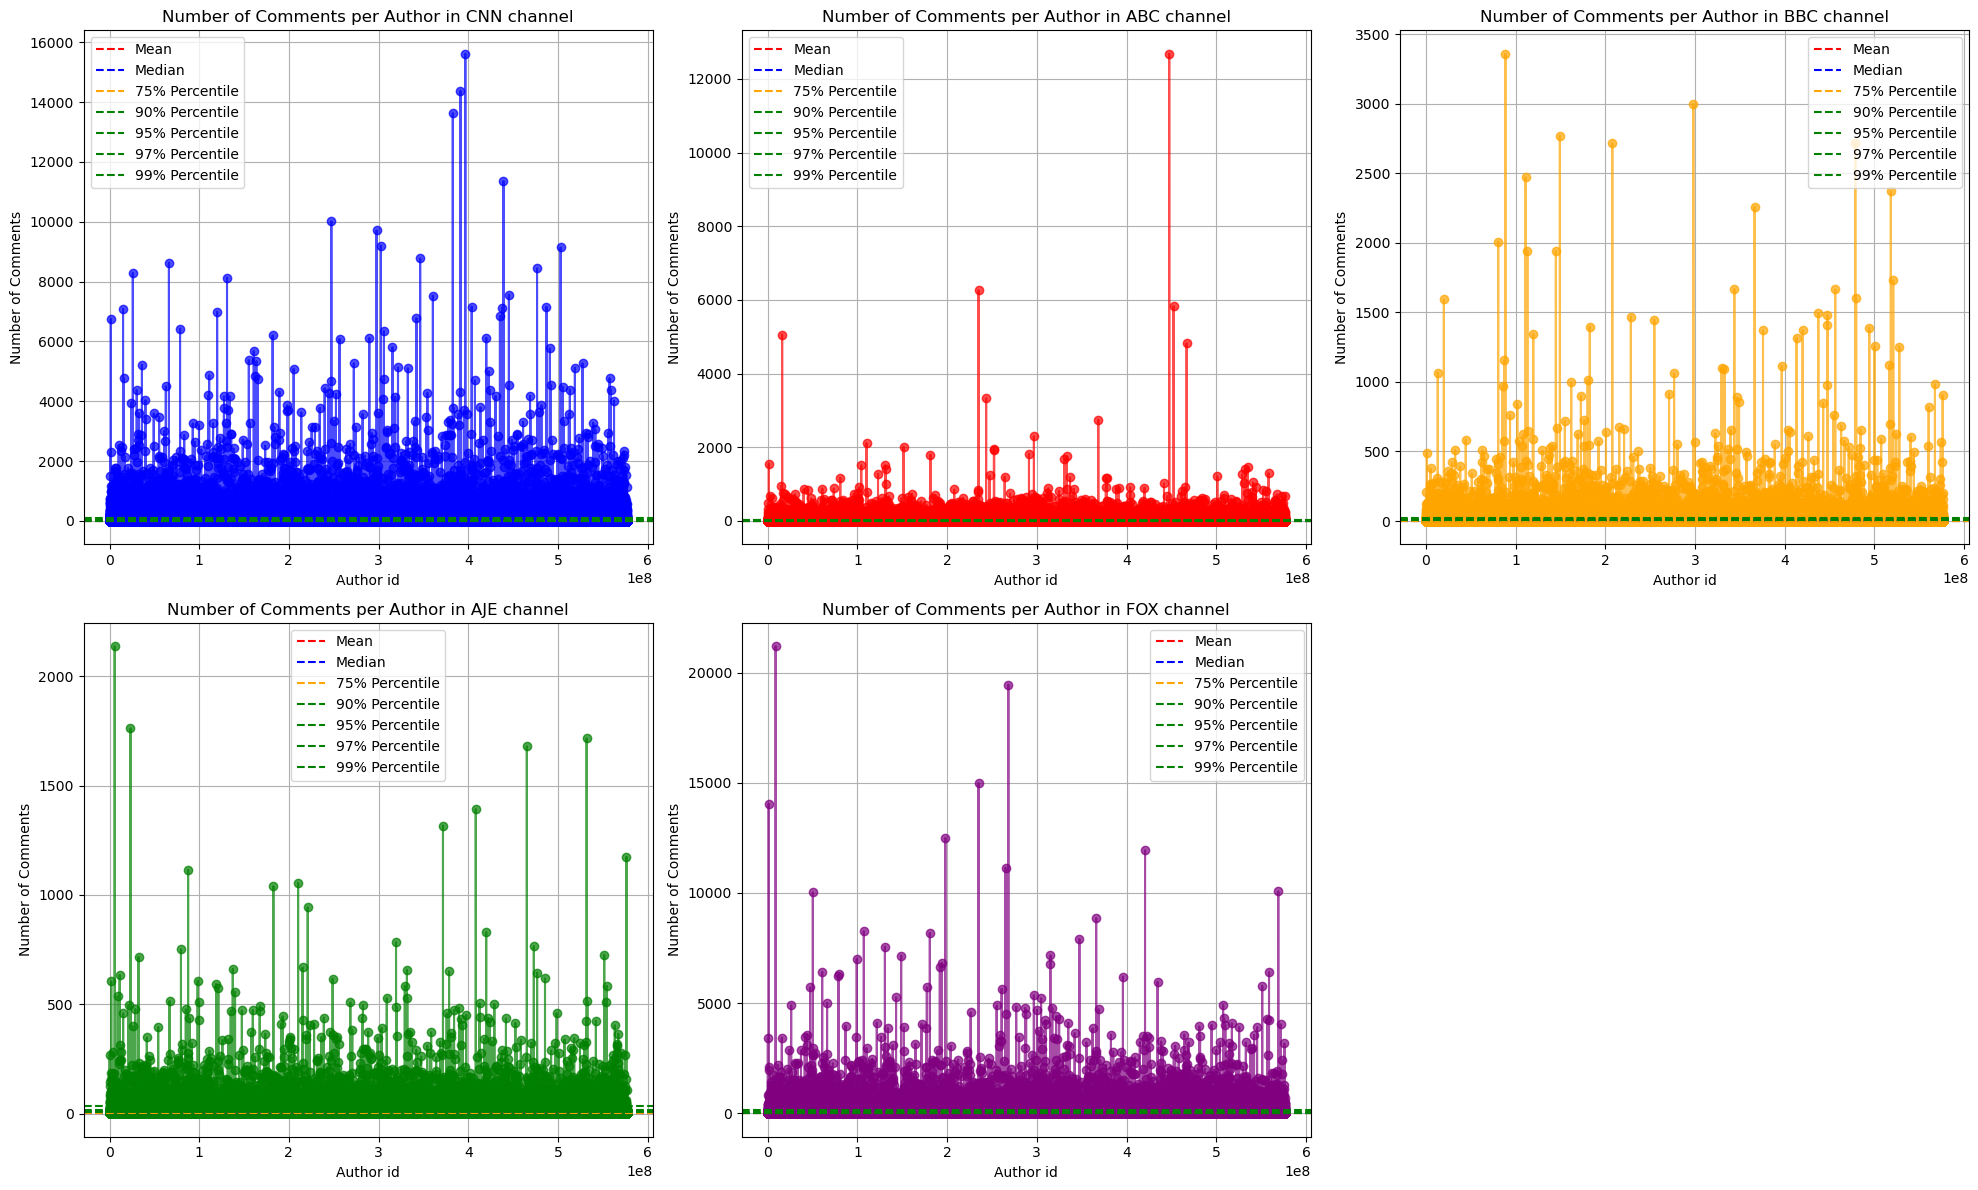

,Mean,Median,75% Percentile,90% Percentile,95% Percentile,97 % Percentile,99% Percentile
cnn,299899,2268335,728636,245623,114279,69177,22895
abc,741751,3322207,1264223,385206,177284,107551,33499
bbc,214495,1028344,370396,107853,55840,31135,10464
aje,89708,506417,126660,54892,25821,16083,5250
fox,230079,871759,484027,174226,89201,52211,17372


In [18]:
# Threshold DETERMINATION
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# List of 5 main channels
channels = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']

# Dictionary to store metadata for each channel
metadata_dict = {}

# Different types of threshold
thresholds_df = pd.DataFrame(columns=["Mean", "Median", "75% Percentile", 
                                      "90% Percentile" ,"95% Percentile" , 
                                      "97 % Percentile", "99% Percentile"], index=channels)

# Loop through each channel to create the plots and calculate thresholds
for idx, channel in enumerate(channels):
    # Create a dictionary for each channel's metadata
    metadata_dict[channel] = {}

    # Get metadata and comment counts for each channel
    metadata_dict[channel]['metadata'] = globals()[f'metadata_commenters_news_pol_{channel}']
    metadata_dict[channel]['comment_counts'] = globals()[f'comment_counts_{channel}']

    # Calculate thresholds for each channel
    mean_channel = metadata_dict[channel]['metadata'].number_of_comments.mean()
    median_channel = metadata_dict[channel]['metadata'].number_of_comments.median()
    
    # 75th Percentile threshold
    percentile_75 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.75)
    percentile_90 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.9)
    percentile_95 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.95)
    percentile_97 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.97)
    percentile_99 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.99)

    # Number of users exceeding the thresholds for each channel
    metadata_dict[channel]['metadata_mean'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], mean_channel)
    metadata_dict[channel]['metadata_median'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], median_channel)
    metadata_dict[channel]['metadata_percentile_75'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_75)
    metadata_dict[channel]['metadata_percentile_90'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_90)
    metadata_dict[channel]['metadata_percentile_95'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_95)
    metadata_dict[channel]['metadata_percentile_97'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_97)
    metadata_dict[channel]['metadata_percentile_99'] = get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_99)

    # Store the threshold results in the DataFrame
    thresholds_df.loc[channel] = [
        len(metadata_dict[channel]['metadata_mean']),
        len(metadata_dict[channel]['metadata_median']),
        len(metadata_dict[channel]['metadata_percentile_75']),
        len(metadata_dict[channel]['metadata_percentile_90']),
        len(metadata_dict[channel]['metadata_percentile_95']),
        len(metadata_dict[channel]['metadata_percentile_97']),
        len(metadata_dict[channel]['metadata_percentile_99'])]
    
    # Plotting the number of comments per author for each channel
    axes[idx].plot(metadata_dict[channel]['comment_counts'].index, metadata_dict[channel]['comment_counts'], marker='o', color=colors[idx], alpha=0.7)
    axes[idx].set_title(f'Number of Comments per Author in {channel.upper()} channel')
    axes[idx].set_xlabel('Author id')
    axes[idx].set_ylabel('Number of Comments')
    axes[idx].grid(True)
    axes[idx].axhline(y=mean_channel, color='r', linestyle='--', label='Mean')
    axes[idx].axhline(y=median_channel, color='b', linestyle='--', label='Median')
    axes[idx].axhline(y=percentile_75, color='orange', linestyle='--', label='75% Percentile')
    axes[idx].axhline(y=percentile_90, color='green', linestyle='--', label='90% Percentile')
    axes[idx].axhline(y=percentile_95, color='green', linestyle='--', label='95% Percentile')
    axes[idx].axhline(y=percentile_97, color='green', linestyle='--', label='97% Percentile')
    axes[idx].axhline(y=percentile_99, color='green', linestyle='--', label='99% Percentile')
    axes[idx].legend()

# Display the threshold results
plt.tight_layout()
axes[5].axis('off')
plt.show()

# Display the thresholds DataFrame
display(thresholds_df)


We will take the thresold : XXX, as it is already a big set of users. It is statistically relevant because it is taking the most active users for each channels. 
I.e, the clusters of the differents channels will be compose of the median+ 2std most active users of each channels

In [4]:
#cluster 

filepath_cnn_cluster= dataset_root_path + "../generated_data/cluster_cnn.csv"
filepath_abc_cluster= dataset_root_path + "../generated_data/cluster_abc.csv"
filepath_bbc_cluster= dataset_root_path + "../generated_data/cluster_bbc.csv"
filepath_aje_cluster= dataset_root_path + "../generated_data/cluster_aje.csv"
filepath_fox_cluster= dataset_root_path + "../generated_data/cluster_fox.csv"

try:
    cluster_cnn = pd.read_csv(filepath_cnn_cluster)
    print("Read data cnn from file")
    cluster_abc = pd.read_csv(filepath_abc_cluster)
    print("Read data abc from file")
    cluster_bbc = pd.read_csv(filepath_bbc_cluster)
    print("Read data bbc from file")
    cluster_aje = pd.read_csv(filepath_aje_cluster)
    print("Read data aje from file")
    cluster_fox = pd.read_csv(filepath_fox_cluster)
    print("Read data fox from file")
except: 

    cluster_cnn = metadata_dict['cnn']['metadata_percentile_99']
    cluster_abc = metadata_dict['abc']['metadata_percentile_99']
    cluster_bbc = metadata_dict['bbc']['metadata_percentile_99']
    cluster_aje = metadata_dict['aje']['metadata_percentile_99']
    cluster_fox = metadata_dict['fox']['metadata_percentile_99']

    
    cluster_cnn.to_csv(filepath_cnn_cluster, index=False)
    cluster_abc.to_csv(filepath_abc_cluster, index=False)
    cluster_bbc.to_csv(filepath_bbc_cluster, index=False)
    cluster_aje.to_csv(filepath_aje_cluster, index=False)
    cluster_fox.to_csv(filepath_fox_cluster, index=False)

    print("Wrote cluster data to 5 files.")

    
display(cluster_cnn, cluster_abc, cluster_bbc, cluster_aje, cluster_fox)

Read data cnn from file
Read data abc from file
Read data bbc from file
Read data aje from file
Read data fox from file


,author,number_of_comments,number_of_videos
0,13221,292,3
1,17554,128,56
2,33093,233,94
3,97609,737,631
4,139895,687,581
...,...,...,...
22890,576458921,200,180
22891,576489820,171,7
22892,576498535,153,124
22893,576498815,1138,405


,author,number_of_comments,number_of_videos
0,13217,48,23
1,16863,65,30
2,17554,42,23
3,33985,53,37
4,52185,37,25
...,...,...,...
33494,576456683,168,122
33495,576457863,73,29
33496,576472312,33,2
33497,576517277,164,114


,author,number_of_comments,number_of_videos
0,38628,31,24
1,155881,209,87
2,157971,29,16
3,216669,26,8
4,242788,38,28
...,...,...,...
10459,576457863,39,18
10460,576481725,27,9
10461,576498815,156,58
10462,576504620,25,13


,author,number_of_comments,number_of_videos
0,83683,37,24
1,97609,269,243
2,174608,51,47
3,511454,50,12
4,540267,52,42
...,...,...,...
5245,575956805,42,40
5246,576016221,48,28
5247,576164605,159,82
5248,576277001,1174,382


,author,number_of_comments,number_of_videos
0,110797,176,98
1,155881,3402,1633
2,229428,146,111
3,232887,153,139
4,242318,834,495
...,...,...,...
17367,576357157,694,603
17368,576456683,290,230
17369,576515899,245,15
17370,576519517,242,229


In [21]:
del metadata_dict
print(gc.collect())

0


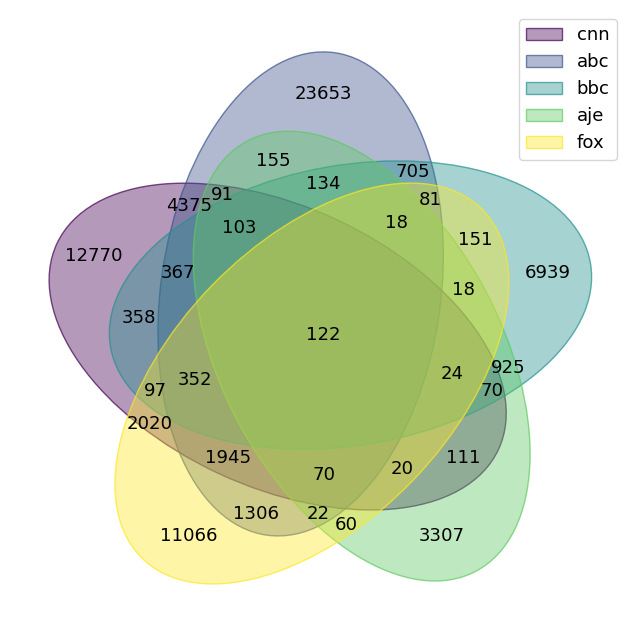

In [5]:
import venn
%matplotlib inline

set_cnn = set(cluster_cnn.author)
set_abc = set(cluster_abc.author)
set_bbc = set(cluster_bbc.author)
set_aje = set(cluster_aje.author)
set_fox = set(cluster_fox.author)
sets = {
    "cnn": set_cnn,
    "abc": set_abc,
    "bbc": set_bbc,
    "aje": set_aje,
    "fox": set_fox
}

venn.venn(sets)
plt.show()

### Analysis
One can see that only 61 users are the most active in all 5 channels! Some other overlaps between channels can be seen, but there is still a high number of users that are specific to only one.

##SHOULD WE CONCENTRATE ONLY ON THESE USERS???

# Part 3 : Identifying bubbles

## Determining the mean pairwise overlap of commented videos for users in our clusters

Here, we are going to get, for each defined cluster, for each pair of users in the clusters, the lists of videos they have commented on. Then we compare these lists to get the common elements, i.e. videos on which both paired users have commented on. We can then divide this by the shortest length among the two lists of videos, thereby getting the fraction of commented videos the paired users have in common. We call this "pairwise overlap of commented videos".

Then, we can for instance calculate the mean pairwise overlap for all users in each cluster, and compare this among the clusters. In particular, we can use a random sample of YouTube users, define it as a control cluster, and calculate its the mean pairwise overlap as well. By comparing the control mean overlap to the values for each of our original clusters, we can see whether we have a higher mean for users that commented frequently under a specific channel than for a random reference sample of users; suggesting that they might have a larger overlap in their interests or at least YouTube watching behaviour.

### Getting the required data

*OLD TEXT AND FUNCTION, WE DON'T REALLY NEED IT ANYMORE*

First, we will need to get for every clustered user the list of video they have commented on.

For this, we have the below function, which takes a dataframe with comment data and a list of users, and returns a dataframe containing one column with the user ids and one column with the lists of videos on which the corresponding user has commented on.

There are however too many comments in news and politics videos to be handled at once, so it needs to be done in chunks. Combining the video lists from the different chunks to a single dataframe still needs to be implemented. But, we show that the function below works on a single dataframe by running it on the first chunk of the cnn comment data.


In [26]:
def get_video_list_for_given_users(comment_data: pd.DataFrame, users: pd.DataFrame, video_ids: pd.DataFrame)-> pd.DataFrame:
    """
    Creates a df with one column for users 
    and one column with the list of videos that user has commented on.
    Args:
        comment_data: a df containing the comments to go through
        users: the list of users to do this for
        
    Returns:
        df as described above
    """
    
    comments_by_given_users_grouped = comment_data.loc[comment_data.author.isin(users)].groupby("author")
    video_ids_of_comments_by_given_users_grouped = comments_by_given_users_grouped['video_id']

    return pd.DataFrame({'author': video_ids_of_comments_by_given_users_grouped.groups.keys(), 
                         'video_list': [comment_data.loc[vid_ids].video_id for vid_ids in video_ids_of_comments_by_given_users_grouped.groups.values()]})


video_list_for_cnn_cluster__chunk_1_filename = dataset_root_path + "../generated_data/video_list_cnn_cluster_chunk_1.json"

if os.path.isfile(video_list_for_cnn_cluster__chunk_1_filename):
    df_video_list_for_cnn_cluster_chunk_1 = pd.read_json(video_list_for_cnn_cluster__chunk_1_filename)
else:
    for i, df_comments_news_pol_chunk in enumerate(pd.read_csv(comments_news_pol_videos_filepath, chunksize=1000000)):
        if i > 0:
            break
        df_video_list_for_cnn_cluster_chunk_1 = get_video_list_for_given_users(df_comments_news_pol_chunk, df_comments_news_pol_cnn.author, df_videos_news_pol_display_ids)
        
        df_video_list_for_cnn_cluster_chunk_1.to_json(video_list_for_cnn_cluster__chunk_1_filename, index=False)
        
    
display(df_video_list_for_cnn_cluster_chunk_1)

,author,video_list
0,269,"{'68': '1TV6JFxMEcI', '69': 'BuQBRtxw-CY', '70..."
1,1015,"{'219': 'b8Jmjloz9_k', '220': 'slXbw677sEY'}"
2,1548,"{'336': '-rN17xNnIyM', '337': '-rN17xNnIyM', '..."
3,1560,"{'345': 'LHoQm8LxEmQ', '346': 'LHoQm8LxEmQ', '..."
4,2097,"{'421': 'IwczRAkQsB4', '422': '5Mp8PNm25gk', '..."
...,...,...
5671,1408976,"{'999259': 'fkSNyrByMQw', '999260': 'A2nklduvT..."
5672,1409369,"{'999391': 'cTwxnUKhF5I', '999392': 'CvnmSRghd..."
5673,1409488,"{'999557': '3X59ndYGMqU', '999558': '6YRs-x7LP..."
5674,1409658,"{'999830': 'wRO9BHbF9GA', '999831': 'ACUmAmWaK..."


It's difficult to make a dataframe with the video ids as rows, the user ids as columns, and the entries as booleans showing whether the user has commented on the video, even though it would be a useful format; as this dataframe would be far too big for the amount of videos and users we're considering at this stage.

But, we can save this information in a sparse matrix instead! This matrix contains only stores those values which are True (the case when a user *has* commented on a video), and all other entries are implied to be False. As any user will only have commented on a small fraction of all News and politics videos, this will take far less memory.

In [27]:
# def get_video_user_comment_matrix(comment_data: pd.DataFrame, users: pd.DataFrame, print_time_every: int = 0)-> pd.DataFrame:
#     """
#     Creates a df with video ids as rows, user ids as columns, and the entries being booleans showing whether the user has commented.
#     and one column with the list of videos that user has commented on.
#     Args:
#         comment_data: a df containing the comments to go through. 
#             Video_id must be integers, corresponding to the assumed ordering of video ids in the matrix!
#             (So for example, you would have to change video ids ['abc', 'xyz', 'pqr'] to [0, 1, 2], 
#             and then change the video id column in the comment data to show, 0, 1, or 2 instead of 'abc', 'xyz' or 'pqr')
#         users: the list of users to do this for. The user ids MUST be integers corresponding to their respective columns in the matrix
#     Returns:
#         df as described above
#     """

#     comments_by_given_users_grouped = comment_data.loc[comment_data.author.isin(users)].groupby("author")
#     video_ids_of_comments_by_given_users_grouped = comments_by_given_users_grouped['video_id']
 
#     rows = []
#     cols = []
#     time_duration_avg = 0
#     for i, (user, vid_indices) in enumerate(video_ids_of_comments_by_given_users_grouped.groups.items()):
#         time_start = time.time()

#         # new row ids are the video ids of the videos the user has commented on
#         new_row_ids = comment_data.loc[vid_indices].video_id.values
#         rows.extend(new_row_ids)

#         # new col ids are simply the column corresponding to the current user. That's why the user id's must correspond to their column ids!
#         cols.extend([user] * len(new_row_ids))
        
        
#         time_end = time.time()

#         # Some timing stuff, not used anymore since the code has gotten fast enough
#         if not not print_time_every:
#             time_duration = time_end - time_start
#             time_duration_avg = (time_duration_avg * i + time_duration) / (i+1)
#             time_left_in_chunk_avg = (len(video_ids_of_comments_by_given_users_grouped.groups) - i) * (time_duration_avg)
#             if i % print_time_every == 0:
#                 print(f"    User {i} of {len(video_ids_of_comments_by_given_users_grouped.groups)}: {time_duration:.3f} s ({time_duration_avg:.3f} s avg)   |   " 
#                     + f"{time_left_in_chunk_avg:.3f} s ({time_left_in_chunk_avg / 60:.3f} min) left.")

#     return rows, cols

For this, there is now a function in the utils file called 'get_video_user_entry_data_for_chunk', which takes comment data and a list of users (i.e., a cluster), and returns the raw data needed to create a sparse boolean matrix where each entry $(i,j)$ indicates whether user $j$ has commented on video $i$.

"Raw data" in this case means: A list of row indices and a list of column entries. The sparse matrix will then be formed such that each pair $(row[k], col[k])$ is a True entry.

However this function only works on single dataframes of comment data, and our comment data (all comments under videos in News and politics) is too big, and we need to read it in chunks.

There is a function 'get_video_user_matrix' in the utils file as well which does this automatically.

There are also further preparation steps which needs to be done, as the functions don't work with the normal video_ids and user_ids; instead they require the id's to correspond to the column and row ids in the matrix.
For example: If the video with id "eh743jss" is in row 312 of the matrix, then the video_id given in the comment data should not be "eh743jss" as it was originally, but it should instead be 312.

(The reason for this is that otherwise, the functions would need to do very time-consuming operations, because for every video they would need to look up in which row it should put a True value. Now instead, it can just put the true value in the row corresponding to the index, no lookup needed)

This is all shown in an example below:

In [28]:
# We create test datasets, to show how the function dp.get_video_user_entry_data_for_chunk works:

# here are a bunch of comments, users and videos we will look at
comments_test = pd.DataFrame({'author':[1, 2, 3, 1, 5, 4, 1], 
                              'video_id':['a', 'b', 'c', 'd', 'e', 'f', 'a']})

users_test = pd.DataFrame({'author': [1, 2, 3, 5]})  
# note that one of the users in the comment data is not part of the user list. This corresponds e.g. to the comment data containing data about comments that were written by someone not in our cluster

videos_test = pd.DataFrame({'display_id': ['a', 'b', 'c', 'd', 'e', 'f']})

print('comments')
display(comments_test)
print('users')
display(users_test)
print('videos')
display(videos_test)

comments


,author,video_id
0,1,a
1,2,b
2,3,c
3,1,d
4,5,e
5,4,f
6,1,a


users


,author
0,1
1,2
2,3
3,5


videos


,display_id
0,a
1,b
2,c
3,d
4,e
5,f


Note that the function above requires the user ids and video ids to correspond to the row and column id's in the matrix

Normally, this will not be the case, for instance, the video ids in the dataset are strings, and while the user ids
are integers, they don't start with 1, and alo we only care about the users in our cluster, so we don't want a column
for other users in our matrix, meaning that we need to assign new indices for the users, 
going from 0 to [number of users in cluster]

This is also true for our example data above, where the display id's are strings and the user id's start at 1, and user 5 is not included in our user list although a comment by user 5 is in the comment data.

Therefore, we are doing a re-indexing:

In [29]:
# take all the available display_ids, remove any duplicates, 
# create a new int index starting from 0, then set the old display id's as index
videos_test_display_id_mapping = (videos_test.display_id  # take the current display ids
    .drop_duplicates()  # remove any diplicates if there are some
    .reset_index(drop=True)  # create a new index which goes from 0 to number of authors (this is stored in the index) (we don't need the old index, so drop=True)
    .reset_index()  # reset index again, in order to move the just created index into a column (with name 'index')
    .set_index(['display_id'])['index'] # set the old display id to be the index, select the new index column
    )  

# This gives a Series which maps each old display id (which is the index of the series) to a new index 
# (which are the values of the Series)
# It looks like this:
print("Video id to int mapping:")
display(videos_test_display_id_mapping)

# Now do the same for user ids and display (take all users in the user list (e.g. a cluster) and give them nice indices)
users_test_user_id_mapping = (users_test.author
                              .drop_duplicates()
                              .reset_index(drop=True)
                              .reset_index()
                              .set_index(['author'])['index']
                              )

print("User id to int mapping:")
display(users_test_user_id_mapping)

# There is a function in the utils file which does this automatically:

videos_test_display_id_mapping = dp.get_int_mapping(videos_test.display_id)
users_test_user_id_mapping = dp.get_int_mapping(users_test.author)

print("Video id to int mapping:")
display(videos_test_display_id_mapping)
print("User id to int mapping:")
display(users_test_user_id_mapping)

Video id to int mapping:


display_id
a    0
b    1
c    2
d    3
e    4
f    5
Name: index, dtype: int64

User id to int mapping:


author
1    0
2    1
3    2
5    3
Name: index, dtype: int64

Video id to int mapping:


display_id
a    0
b    1
c    2
d    3
e    4
f    5
Name: index, dtype: int64

User id to int mapping:


author
1    0
2    1
3    2
5    3
Name: index, dtype: int64

Now we can use these mappings to change the user and video ids in our example datarames:

In [30]:
comments_test.author = comments_test.author.map(users_test_user_id_mapping).dropna().astype(int)  # correct the user ids in comment data
users_test.author = users_test.author.map(users_test_user_id_mapping).dropna().astype(int)  # correct the user ids in the user list
comments_test.video_id = comments_test.video_id.map(videos_test_display_id_mapping)  # correct the video ids in the comment df
videos_test.display_id = videos_test.display_id.map(videos_test_display_id_mapping)  # correct the video ids in the video df

# Look at the results, now we have correct indices!
display(comments_test)
display(users_test)
display(videos_test)

,author,video_id
0,0.0,0
1,1.0,1
2,2.0,2
3,0.0,3
4,3.0,4
5,NaN,5
6,0.0,0


,author
0,0
1,1
2,2
3,3


,display_id
0,0
1,1
2,2
3,3
4,4
5,5


Note that in the comment data, we now have a NaN value, and the numbers are now numpy floats instead of integers.
This both comes from the fact that our mapping does not include a value for user 5, as we don't want to consider this user, and therefore they will not get a column in the matrix. 

So this is not a problem, we only have to consider later to convert float values to ints (we cannot do it now, beause NaN is not an int)

In [31]:
# we then use the function to get the indices of rows and columns where we will later set the value to "true":
# that means, we get an array of row indices and an array of column indices, and then always the first row index 
# with the first column index specify a location of a true value, i.e., a video (=row) which has been commented by a user (column)

test_rows_and_cols = dp.get_video_user_entry_data_for_chunk(comment_data=comments_test, users=users_test.author)
display(test_rows_and_cols[0])  # row indices
display(test_rows_and_cols[1])  # column indices

# so in this case, the points (0, 0), (3, 0), (0, 0), (1, 1), (2, 2), (5, 3) will get true values in our matrix
# meaning that user 0 has commented video 0 twice and video 3 once; user 1 has commented video 1, 
# user 2 has commented video 2, user 3 has commented video 5

[np.int64(0), np.int64(3), np.int64(0), np.int64(1), np.int64(2), np.int64(4)]

[0.0, 0.0, 0.0, 1.0, 2.0, 3.0]

Note that these indices (when we are talking about "user 1" has commented "video 1" etc) are of course our new indices!

We will see two notebook cells further down that they correspond to the matrix entries, as expected.

If we want to get back the original indices, we can reverse the indexing mapping again.
But right now, we don't really need that. Because we are looking for mean pairwise overlap, so what we call the users
and the videos is not important, we just want to know how many videos they generally have in common.

But if we want to do it (for example, later on it might be important to look at which video it actually was) then it can be done like this:

In [32]:
test_rows_original_index = pd.Series(test_rows_and_cols[0]).map({new_ind:display_id for display_id, new_ind in videos_test_display_id_mapping.items()}).to_numpy()

display(test_rows_original_index)

test_cols_original_index = pd.Series(test_rows_and_cols[1]).map({new_ind:user_id for user_id, new_ind in users_test_user_id_mapping.items()}).to_numpy()

display(test_cols_original_index)

# There is also a function for this in the utils file:
test_rows_original_index = pd.Series(test_rows_and_cols[0]).map(dp.get_inverse_int_mapping(videos_test_display_id_mapping)).to_numpy()
test_cols_original_index = pd.Series(test_rows_and_cols[1]).map(dp.get_inverse_int_mapping(users_test_user_id_mapping)).to_numpy()

display(test_rows_original_index)
display(test_cols_original_index)

array(['a', 'd', 'a', 'b', 'c', 'e'], dtype=object)

array([1, 1, 1, 2, 3, 5])

array(['a', 'd', 'a', 'b', 'c', 'e'], dtype=object)

array([1, 1, 1, 2, 3, 5])

So this would instead give the row, col pairs (a, 1), (d, 1), (a, 1), (b, 2), (c, 3), (f, 4)

Whis is more easily interpretable as "video a has been commented on by user 1 twice, video d has been commented on by user 1, etc."

In [33]:
# Now we go back to use our row and column data for the "new" indices (the int indices) to generate our sparse matrix 
# (the matrix is basically stored using these lists of row and column indices, 
# any entry corresponding to such an index pair is considered "True", any other entry is "False" 
# (and therefore doesn't have to be stored explicitly)

# first we need a vector containing our matrix data. In this case, all of our data is "True", 
# because we only assign the true values, as every matrix entry which isn't assigned a value is considered to be "False" automatically
data = np.ones_like(test_rows_and_cols[0])  # a vector full of "True", the same length as our list of row indices

# now generate the matrix, by passing the data, and our row and column indices
test_sparse_matrix = scipy.sparse.coo_array((data, (np.array(test_rows_and_cols[0], dtype=int), 
                                                    np.array(test_rows_and_cols[1], dtype=int))
                                                    ), 
                                            dtype=bool)

print('Print sparse matrix:')
display(test_sparse_matrix)  # when displaying the sparse matrix as it is, we don't see anything. That's the point, that makes it take up less apce and memory

print('Print sparse matrix converted to dense (normal) matrix:')
display(test_sparse_matrix.todense())  # using todense, we can get the normal matrix representation. 
# We see that the values correspond to the data we defined above (columns are users, rows are videos, value shows whether the user has commented under the video)

Print sparse matrix:


<COOrdinate sparse array of dtype 'bool'
	with 6 stored elements and shape (5, 4)>

Print sparse matrix converted to dense (normal) matrix:


array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [ True, False, False, False],
       [False, False, False,  True]])

## Saving video-author matrices for cluster members

### Set filenames, generate mapping from video id to integer for all videos in News&Pol

In [9]:
# filenames where we want to save the video-author matrices for our clusters
# (note they are not csv files but npz files, I think that is a numpy file format)
video_author_matrix_cnn_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_cnn_cluster.npz"
video_author_matrix_abc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_abc_cluster.npz"
video_author_matrix_bbc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_bbc_cluster.npz"
video_author_matrix_aje_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_aje_cluster.npz"
video_author_matrix_fox_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_fox_cluster.npz"

# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.

video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)


### Load or generate the video-user matrices for all clusters

In [10]:
# CNN

# if the file exists, load it
if os.path.isfile(video_author_matrix_cnn_cluster_filename):
    video_author_matrix_cnn_cluster = scipy.sparse.load_npz(video_author_matrix_cnn_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_cnn_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_cnn.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_cnn_cluster_filename,
    print_stats=True
                                                               )

# ABC

# if the file exists, load it
if os.path.isfile(video_author_matrix_abc_cluster_filename):
    video_author_matrix_abc_cluster = scipy.sparse.load_npz(video_author_matrix_abc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_abc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_abc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_abc_cluster_filename,
    print_stats=True
                                                               )
    
# BBC

# if the file exists, load it
if os.path.isfile(video_author_matrix_bbc_cluster_filename):
    video_author_matrix_bbc_cluster = scipy.sparse.load_npz(video_author_matrix_bbc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_bbc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_bbc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_bbc_cluster_filename,
    print_stats=True
                                                               )
    
# AJE

# if the file exists, load it
if os.path.isfile(video_author_matrix_aje_cluster_filename):
    video_author_matrix_aje_cluster = scipy.sparse.load_npz(video_author_matrix_aje_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_aje_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_aje.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_aje_cluster_filename,
    print_stats=True
                                                               )

# FOX

# if the file exists, load it
if os.path.isfile(video_author_matrix_fox_cluster_filename):
    video_author_matrix_fox_cluster = scipy.sparse.load_npz(video_author_matrix_fox_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_fox_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_fox.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_fox_cluster_filename,
    print_stats=True
                                                               )
    

Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file


In [35]:
# In order to get a column i, meaning information about which videos user i has watched, do this:
display(video_author_matrix_cnn_cluster.getcol(1))

# or if you need them as a non sparse matrix, use:
display(video_author_matrix_cnn_cluster.getcol(0).toarray())

# (for most operations, we should not need this! It is good to keep using the sparse format when possible)

<Compressed Sparse Column sparse matrix of dtype 'bool'
	with 271 stored elements and shape (7551328, 1)>

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [36]:
# So for example, to get the overlap of two users i and j
# (The answer to the question "How many videos have both user i and user j commented on?"),
# you can do:

common_videos_user1_user5 = video_author_matrix_cnn_cluster.getcol(1).multiply(video_author_matrix_cnn_cluster.getcol(5))

# number of common videos
overlap_user1_user5 = common_videos_user1_user5.sum()

# number of common videos, normalized w.r.t. the average number of videos the two users have commented on
normed_overlap_user1_user5 = overlap_user1_user5 / np.mean(
    [video_author_matrix_cnn_cluster.getcol(1).sum(),  # number of videos user 1 has commented on
     video_author_matrix_cnn_cluster.getcol(5).sum()]) # number of videos user 5 has commented on

display(common_videos_user1_user5)
display(overlap_user1_user5)
display(normed_overlap_user1_user5)

# There are functions in the utils file which do this automatically:

common_videos_user1_user5 = dp.common_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)
overlap_user1_user5 = dp.num_common_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)
normed_overlap_user1_user5 = dp.normed_num_commented_videos(video_author_matrix_cnn_cluster, 50, 10000)

display(common_videos_user1_user5)
display(overlap_user1_user5)
display(normed_overlap_user1_user5)

<Compressed Sparse Column sparse matrix of dtype 'bool'
	with 3 stored elements and shape (7551328, 1)>

np.int64(3)

np.float64(0.001244296972210701)

<Compressed Sparse Column sparse matrix of dtype 'bool'
	with 3 stored elements and shape (7551328, 1)>

np.int64(3)

np.float64(0.004338394793926247)

### Creating mappings to recover the original video and user id's

In [37]:
# If we need to recover the original video id, we can use the following mapping:

recover_original_video_id_news_pol = dp.get_inverse_int_mapping(video_ids_news_pol_int_mapping)

# Example:
example_video_ints = pd.Series([1, 4, 5, 8, 9], name='display_id')  # e.g. someone has watched these videos

example_original_video_ids = example_video_ints.map(recover_original_video_id_news_pol)

display(example_original_video_ids)

0    _dIIEMvH86k
1    AbH3pJnFgY8
2    QBuwj_h1SH4
3    HzikGVcKNe4
4    nR7uZZ6yTo4
Name: display_id, dtype: object

In [31]:
# If we need to recover the original user id's, we can use the following mappings:

# CNN
recover_original_user_ids_cnn_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_cnn.author))
# ABC
recover_original_user_ids_abc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_abc.author))
# BBC
recover_original_user_ids_bbc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_bbc.author))
# AJE
recover_original_user_ids_aje_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_aje.author))
# FOX
recover_original_user_ids_fox_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_fox.author))

# example for cnn:
example_user_ints_cnn = pd.Series([1, 67, 2, 4, 6], name='author')  # some users from cnn cluster

example_original_user_ids_cnn = example_user_ints_cnn.map(recover_original_user_ids_cnn_cluster)
display(example_original_user_ids_cnn)

0      17554
1    1380847
2      33093
3     139895
4     157869
Name: author, dtype: int64

### Getting the random sample of users

We are selecting a random sample of Youtube users. We will take 

In [40]:
filepath_cnn_cluster= dataset_root_path + "../generated_data/cluster_cnn.csv"
filepath_abc_cluster= dataset_root_path + "../generated_data/cluster_abc.csv"
filepath_bbc_cluster= dataset_root_path + "../generated_data/cluster_bbc.csv"
filepath_aje_cluster= dataset_root_path + "../generated_data/cluster_aje.csv"
filepath_fox_cluster= dataset_root_path + "../generated_data/cluster_fox.csv"

try:
    cluster_cnn = pd.read_csv(filepath_cnn_cluster)
    print("Read data cnn from file")
    cluster_abc = pd.read_csv(filepath_abc_cluster)
    print("Read data abc from file")
    cluster_bbc = pd.read_csv(filepath_bbc_cluster)
    print("Read data bbc from file")
    cluster_aje = pd.read_csv(filepath_aje_cluster)
    print("Read data aje from file")
    cluster_fox = pd.read_csv(filepath_fox_cluster)
    print("Read data fox from file")
except: 
    cluster_cnn.to_csv(filepath_cnn_cluster, index=False)
    cluster_abc.to_csv(filepath_abc_cluster, index=False)
    cluster_bbc.to_csv(filepath_bbc_cluster, index=False)
    cluster_aje.to_csv(filepath_aje_cluster, index=False)
    cluster_fox.to_csv(filepath_fox_cluster, index=False)

Read data cnn from file
Read data abc from file
Read data bbc from file
Read data aje from file
Read data fox from file


In [ ]:
#getting the average size of the main channels clusters as size for the control sample
control_size = ((len(cluster_cnn)+len(cluster_abc)+len(cluster_aje)+len(cluster_abc)+len(cluster_fox))/5).__round__()
control_size

22503

In [ ]:
#getting the total number of commenters in the NP category
authors = []
for chunk in pd.read_csv(dataset_root_path + "../generated_data/comments_news_pol_videos.csv", chunksize=1000000 ):
        authors.extend(chunk['author'].unique().tolist())  # Get the author id in each chunck 
print(len(authors))

35870979


In [43]:
#generating a ramdom list of numbers for the control sample
import random

control_sample_indexes = random.sample(range(0,35870979), k=22503)
print(control_sample_indexes)

[5979726, 24162117, 28917605, 7090835, 34228454, 34006214, 7951592, 599228, 34366256, 26105839, 21776657, 8043873, 3643159, 19505211, 26911890, 10710425, 17218688, 29031829, 31031417, 5299169, 5956927, 16114187, 32087765, 27531675, 33702274, 17760938, 31333116, 24440657, 32324240, 35561154, 25977130, 24020908, 9768702, 24009106, 12741970, 31436587, 22013994, 16554379, 21445800, 5662230, 35739396, 2611935, 10153222, 17073871, 24562256, 34832659, 25088297, 13608514, 32014611, 10089716, 13860876, 26301239, 24455369, 33244812, 18820426, 35572144, 12141781, 34036667, 32779865, 26556827, 35044392, 24076260, 31355679, 32052353, 30979253, 13356727, 34689008, 616234, 15966255, 24964359, 9571202, 22932460, 12944392, 1962179, 23536325, 8288369, 30298005, 16972056, 5234259, 6980902, 18120891, 19590192, 20042228, 30828001, 17373367, 32989105, 11196515, 31988584, 3113884, 6456884, 29694282, 24334251, 8089688, 24072157, 6420323, 234173, 22033670, 11710862, 14080490, 8505229, 16743692, 33717538, 10475

In [44]:
#generating the control sample

control_sample_author_ids = [authors[i] for i in control_sample_indexes]
print(control_sample_author_ids)

[96097318, 388339416, 464814007, 113966376, 550127834, 546548960, 127769417, 9632127, 552346015, 419579306, 349966677, 129252863, 58539736, 313441899, 432526418, 172122964, 276734691, 466641734, 498781295, 85165807, 95732741, 258959577, 515732169, 442499186, 541664932, 285427991, 503601247, 392820151, 519536794, 571565441, 417501503, 386067885, 156972964, 385874636, 204780604, 505262278, 353781745, 266036940, 344631000, 91003151, 574430679, 41973533, 163148382, 274408973, 394769539, 559840316, 403216026, 218700726, 514564474, 162128482, 222758608, 422707163, 393055169, 534316846, 302449395, 571741180, 195135632, 547038921, 526846582, 426808683, 563247760, 386955750, 503962251, 515170574, 497946389, 214661443, 557530910, 9907536, 256583853, 401232219, 153800034, 368558603, 208036898, 31540394, 378264006, 133181343, 487000914, 272776101, 84120962, 112193441, 291225087, 314816060, 322090675, 495520722, 279206979, 530213248, 179955525, 514147145, 50047716, 103764973, 477280626, 391113188, 

### Testing overlap calculations

In [26]:
print(video_author_matrix_cnn_cluster.shape)
print(video_author_matrix_bbc_cluster.shape)
print(video_author_matrix_cnn_cluster.shape[1])



(7551328, 22895)
(7551328, 10464)
22895


In [ ]:
def jaccard_index_different_clusters1(cluster1, cluster2, original_userid1, original_userid2):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        original_user1 = original_userid1[i]
        user1_array = cluster1.getcol(i).toarray().flatten()
        for j in range(cluster2.shape[1]):
            original_user2 = original_userid2[j]
            if original_user1!=original_user2 : 
                user2_array = cluster2.getcol(j).toarray().flatten()
                jaccard_list.append(jaccard_score(user1_array,user2_array))
    
    overall_jaccard = sum(jaccard_list)/len(jaccard_list)

    return overall_jaccard, jaccard_list
'''
def jaccard_index_same_cluster(cluster1):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        user1_array = cluster1.getcol(i).toarray().flatten()
        for j in range(i+1, cluster1.shape[1]): 
            user2_array = cluster1.getcol(j).toarray().flatten()
            jaccard_list.append(jaccard_score(user1_array,user2_array))
    
    overall_jaccard = sum(jaccard_list)/len(jaccard_list)
    
    return overall_jaccard, jaccard_list
'''
#other way of coding the function

def jaccard_index_different_clusters(cluster1, cluster2, original_userid1, original_userid2):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        original_user1 = original_userid1[i]
        for j in range(cluster2.shape[1]):
            original_user2 = original_userid2[j]
            if original_user1!=original_user2 : 
                TT = cluster1.getcol(i).multiply(cluster2.getcol(j))
                #print(TT.sum())
                TF = (cluster1.getcol(i)-cluster2.getcol(j)).multiply(cluster1.getcol(i))
                #print(TF.sum())
                FT = (cluster2.getcol(j)-cluster1.getcol(i)).multiply(cluster2.getcol(j))
                #print(FT.sum())
                jaccard_list.append((TF.sum()+FT.sum())/(TT.sum()+TF.sum()+FT.sum()))

    overall_jaccard = sum(jaccard_list)/len(jaccard_list)

    return overall_jaccard, jaccard_list

def jaccard_index_same_cluster(cluster1):
    jaccard_list = []
    for i in range(cluster1.shape[1]):
        for j in range(i+1, cluster1.shape[1]): 
            common_videos = cluster1.getcol(i).multiply(cluster1.getcol(j))
            jaccard_list.append(common_videos.sum()/(cluster1.getcol(i).sum() +cluster1.getcol(j).sum()))
    
    overall_jaccard = sum(jaccard_list)/len(jaccard_list)
    
    return overall_jaccard, jaccard_list

# an other other way (matrix)

'''
def jaccard_index_different_clusters(cluster1, cluster2):
    # Create sparse matrices of ones for each cluster
    cluster1_1 = scipy.sparse.csc_matrix((cluster1.shape[0], cluster1.shape[1]))
    cluster1_1.data = [1] * len(cluster1.data)
    
    cluster2_1 = scipy.sparse.csc_matrix((cluster2.shape[0], cluster2.shape[1]))
    cluster2_1.data = [1] * len(cluster2.data)

    # Calculate (1 - cluster1) and (1 - cluster2)
    cluster1_neg = cluster1_1 - cluster1
    cluster2_neg = cluster2_1 - cluster2

    # Perform operations (dot products)
    TT = cluster1.T.dot(cluster2)  # Matching rows and columns
    TF = cluster1.T.dot(cluster2_neg)  # Matches rows of cluster1 to columns of (1-cluster2)
    FT = cluster1_neg.T.dot(cluster2)  # Matches rows of (1-cluster1) to columns of cluster2
    
    # Safeguard against division by zero
    denom = TT + FT + TF
    denom.data[denom.data == 0] = 1  # Prevent division by zero
    
    # Calculate Jaccard index
    jaccard = (TF + FT) / denom

    TT = cluster1.transpose().dot(cluster2)
    TF = cluster1.transpose().dot(1-cluster2)
    FT = (1-cluster1).transpose().dot(cluster2)
    jaccard = (TF+FT)/(TT+FT+TF)

    return jaccard

def jaccard_index_same_cluster(cluster1):
    TT = cluster1.transpose().dot(cluster1)
    TF = cluster1.transpose().dot(1-cluster1)
    FT = (1-cluster1).transpose().dot(cluster1)
    jaccard = (TF+FT)/(TT+FT+TF)

    return jaccard'''

troncate_matrix_cnn = video_author_matrix_cnn_cluster[:, :5]
troncate_matrix_bbc = video_author_matrix_bbc_cluster[:, :3]

jaccard_cnn_bbc, jaccard_list_cnn_bbc = jaccard_index_different_clusters(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)
jaccard_cnn_bbc1, jaccard_list_cnn_bbc1 = jaccard_index_different_clusters1(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)

print(jaccard_cnn_bbc)
print(jaccard_cnn_bbc1)
print(1-jaccard_cnn_bbc)

0.999350721458441
0.0006492785415590793
0.0006492785415590507


## Examine whether there are multiple users' bubbles within a cluster (trying with FOX for now)

Now we are looking for users' bubbles in the same cluster based on the **similarity of commented videos**, using DBSCAN algorithm. 

Here are the steps :

- Take Andrea's sparse matrix of a cluster (columns = users, rows = videos), where booleans indicate if the user has commented on a video or not

- Transform the sparse matrix to a distance matrix using the Cosine distance method, which returns a jxj matrix ( j = number of users of the cluster ) containing integers between 0-1, which indicate the distance between each pair of users in terms of commenting behavior (0=close=similar, 1=distant=not similar)

        NOTE: here is how the cosine distance method works, and why I chose it over Jaccard:
        blabla

- Choose the optimal **min_samples** parameter for DBSCAN, i.e the minimum number of users in a bubble (minimum bubble size).

- Choose the optimal **eps** parameter for DBSCAN, i.e the minimum distance between two users for them to be considered in the same cluster. If eps is too low, many users will be classified as outliers (bubble '-1').
To do so, plot the k-distance graph and take the value on y-axis at the elbow point. On this plot, we see the distance between one user ('point' on x-axis) and its closest neighbors (defined by the min_samples - the current user )

- Run DBSCAN on the distance matrix: what is returned, 'labels', is the assigned bubble for each user (1D list of integers, and '-1' bubble is for outliers). The user id is not specified, but this 'label' list is in the same order as the columns in the input distance matrix.

- Group users of the initial cluster by bubble (user id mapping is required here)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Calculate pairwise distances (cosine distances between users)
# Using the video-author matrix transposed as your input matrix
distance_matrix = pairwise_distances(video_author_matrix_fox_cluster.T, metric='cosine')

In the following cells, we explore the data about FOX users to help us choose eps and min_samples for DBSCAN: sparsity between users, max and min distance between users, k-distances plots (which are not very useful in the end, as eps appears to be too small on the graph), and lastly, testing some combinations.

In [ ]:
# Measure sparsity of the data
nonzero_elements = video_author_matrix_fox_cluster.nnz
total_elements = video_author_matrix_fox_cluster.shape[0] * video_author_matrix_fox_cluster.shape[1]
sparsity = 1 - (nonzero_elements / total_elements)

print(f"Sparsity: {sparsity:.4f}")

# Adjust DBSCAN parameters based on sparsity
if sparsity > 0.70:
    print("Data is sparse. Consider smaller eps and min_samples.")
    eps = 0.05
    min_samples = 5
else:
    print("Data is dense. Consider larger eps and min_samples.")
    eps = 0.1
    min_samples = 10

Sparsity: 0.9999
Data is sparse. Consider smaller eps and min_samples.


In [19]:
# Get the minimum and maximum cosine distance values to know in which range EPS has to be
min_distance = np.min(distance_matrix)
max_distance = np.max(distance_matrix)

print(f"Minimum Cosine Distance: {min_distance}")
print(f"Maximum Cosine Distance: {max_distance}")

Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0


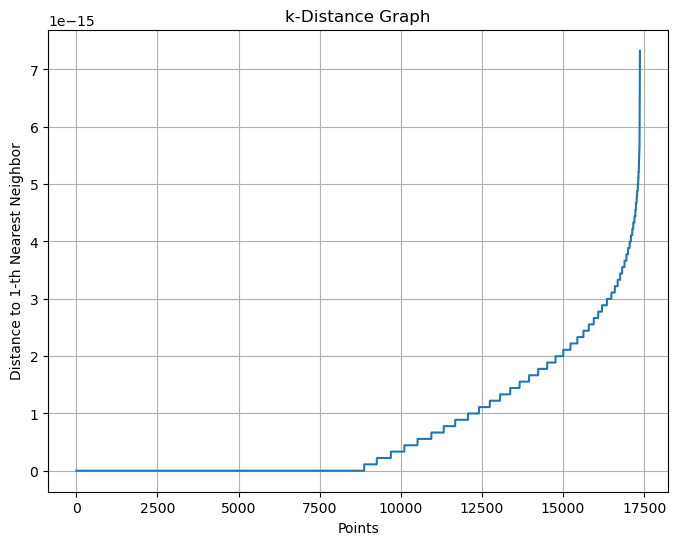

KeyboardInterrupt: 

In [18]:
#plot k-distance graph with different candidates min_samples values

candidate_min_samples = [2, 5, 10, 20]

for min_sample in candidate_min_samples:
    # Find the k-nearest neighbors (k = min_samples - 1)
    k = min_sample - 1
    neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
    neighbors.fit(distance_matrix)

    # Compute the distances to the k-th nearest neighbor for each user
    distances, indices = neighbors.kneighbors(distance_matrix)

    # Plot the k-distance graph (sorted distances)
    plt.figure(figsize=(8, 6))  
    plt.plot(np.sort(distances[:, -1]))  # distances to the k-th nearest neighbor
    plt.title("k-Distance Graph")
    plt.xlabel("Points")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.grid(True)
    plt.show()


Now we try bubbling the FOX users with several eps/min_samples combinations until we obtain a satisfactory result, i.e some bubbles and not tooo many outliers.

In [ ]:
eps_values = [0.6, 0.8, 0.9]
min_samples_values = [4, 5, 10, 50, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        # Count clusters and outliers
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_clusters} clusters, {n_outliers} outliers")

eps=0.600000, min_samples=4: 0 clusters, 17372 outliers
eps=0.600000, min_samples=5: 0 clusters, 17372 outliers
eps=0.600000, min_samples=10: 0 clusters, 17372 outliers
eps=0.600000, min_samples=50: 0 clusters, 17372 outliers
eps=0.600000, min_samples=100: 0 clusters, 17372 outliers
eps=0.800000, min_samples=4: 8 clusters, 17014 outliers
eps=0.800000, min_samples=5: 5 clusters, 17031 outliers
eps=0.800000, min_samples=10: 3 clusters, 17056 outliers
eps=0.800000, min_samples=50: 2 clusters, 17180 outliers
eps=0.800000, min_samples=100: 0 clusters, 17372 outliers
eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
eps=0.900000, min_samples=5: 6 clusters, 11868 outliers
eps=0.900000, min_samples=10: 3 clusters, 11989 outliers
eps=0.900000, min_samples=50: 1 clusters, 12555 outliers
eps=0.900000, min_samples=100: 1 clusters, 12863 outliers


In [13]:
eps_values = [0.85, 0.88, 0.95]
min_samples_values = [4, 5, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        # Count clusters and outliers
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_clusters} clusters, {n_outliers} outliers")

eps=0.850000, min_samples=4: 15 clusters, 15963 outliers
eps=0.850000, min_samples=5: 11 clusters, 15985 outliers
eps=0.850000, min_samples=10: 4 clusters, 16109 outliers
eps=0.880000, min_samples=4: 12 clusters, 14200 outliers
eps=0.880000, min_samples=5: 7 clusters, 14240 outliers
eps=0.880000, min_samples=10: 3 clusters, 14356 outliers
eps=0.950000, min_samples=4: 1 clusters, 2012 outliers
eps=0.950000, min_samples=5: 1 clusters, 2024 outliers
eps=0.950000, min_samples=10: 1 clusters, 2059 outliers


In [14]:
eps_values = [0.89, 0.91, 0.93]
min_samples_values = [4, 5, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        # Count clusters and outliers
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_clusters} clusters, {n_outliers} outliers")

eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
eps=0.890000, min_samples=5: 6 clusters, 13174 outliers
eps=0.890000, min_samples=10: 3 clusters, 13310 outliers
eps=0.910000, min_samples=4: 3 clusters, 10239 outliers
eps=0.910000, min_samples=5: 2 clusters, 10274 outliers
eps=0.910000, min_samples=10: 2 clusters, 10390 outliers
eps=0.930000, min_samples=4: 4 clusters, 6149 outliers
eps=0.930000, min_samples=5: 2 clusters, 6177 outliers
eps=0.930000, min_samples=10: 1 clusters, 6288 outliers


Interesting parameter combinations for the FOX cluster:

    eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
    eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
    eps=0.910000, min_samples=4: 3 clusters, 10239 outliers

Parameters chosen : 

    eps = 0.9 
    min_samples = 4    

In [ ]:
#apply dbscan on distance_matrix computed above with the selected parameters
opt_eps = 0.9
opt_min_samples = 4

model = DBSCAN(eps=opt_eps, min_samples=opt_min_samples, metric='precomputed')

#1D array containing the bubble to which each user belongs, in the same order of the users of sparse matrix
labels = model.fit_predict(distance_matrix.T)                                   

# Count clusters and outliers
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)

print(f"eps={eps:.6f}, min_samples={min_samples}: {n_clusters} clusters, {n_outliers} outliers")

eps=0.050000, min_samples=5: 7 clusters, 11834 outliers


In [ ]:
#map bubble assignment to original user id
'''
#assign users to bubbles in a copied df of the users ids
dbscanned_cluster_fox = cluster_fox.copy()
dbscanned_cluster_fox['dbscan bubble'] = labels
print(dbscanned_cluster_fox)

#group users by bubble 
dbscan_bubbles_fox = dbscanned_cluster_fox.groupby('dbscan bubble').size()
print(dbscan_bubbles_fox)
'''

In [ ]:
#visualize bubbles using PCA
'''
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(video_author_matrix_fox_cluster.T.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.colorbar(label='Cluster Label')
plt.title('PCA Visualization of User Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
'''